In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
import seawater

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
# Similar to 14 except removed all the processing code.

### Plan

Need to compare New Production, CO2 flux and SST at different locations and for different timescale resolutions. 
Assess which is the best Ensemble for Each of these.


What do we need

- Work in mols.


- CAFE New Production (Need to make detritus calculation)
- CO2 flux 

- New Production estimates
- Chlor A in mg CHL? 
- Landschutzer CO2 flux estimate (How about DELTA pCO2?)
- Reynolds OISST product


- And then detrend and deseasonalise to get different data product resolutions.

- Plot all ensembles over a Year?


In [3]:
#client

In [4]:
# Assumes data was loaded previously in 12 Validation run
use_dask=True
ensemble=25

In [5]:
if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    #cluster = SLURMCluster(cores=8,processes=2,memory="47GB")
    client = Client(cluster)
    cluster.scale(cores=12)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45923 instead
  warnings.warn(


In [6]:
cluster

In [7]:
client

<Client: 'tcp://10.0.128.164:37679' processes=0 threads=0, memory=0 B>

In [8]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

<xarray.Dataset>
Dimensions:          (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [162]:
ls /g/data/xv83/dcfp/CAFE60v1

atmos_isobaric_daily.zarr.zip*  ocean_daily.zarr.zip*
atmos_isobaric_month.zarr.zip*  ocean_ens_mean_at_analysis.zarr.zip*
ice_month.zarr.zip*             ocean_force_month.zarr.zip*
land_month.zarr.zip*            ocean_month.zarr.zip*
ocean_bgc_daily.zarr.zip*       ocean_scalar_month.zarr.zip*
ocean_bgc_month.zarr.zip*


In [9]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40),)

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, sw_ocean: 50, lon_x: 171, lat_x: 141)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-11-01
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 120.0 121.0 122.0 ... 289.0 290.0
  * lat                     (lat) float64 -39.41 -38.44 -37.46 ... 38.38 39.34
  * lat_x                   (lat_x) float64 -39.9 -38.92 -37.95 ... 38.86 39.81
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 140, 171), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [10]:
# Load OBS

# Landschutzer
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-40,40))/12)*1000#/1000 #mmol/m2/day to match cafe. (ingassing is positive, outgassing neg)
#land_dpco2=(land_co2.pco2.sel(lon=slice(120,290),lat=slice(-40,40))


# Reynolds SST
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst=rey_sst.sst.sel(lon=slice(120,290),lat=slice(-40,40))
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
#(obs_current.U_320.median(dim='time').sel(lat=0,method='nearest')).interpolate_na(dim='depth').plot.contourf(cmap='bwr')

In [11]:
# TOA Moorings
run_obs_current=False
if run_obs_current==True:
    obs_current=xr.open_mfdataset('../external_data/mooring_u_current/*.cdf')
    obs_current=obs_current.where(obs_current<=1e20)/100
    obs_current['time']=obs_current.time.astype('datetime64[M]')
    obs_current.to_netcdf('../processed_data/tao_adcp.nc')
obs_current=xr.open_dataset('../processed_data/tao_adcp.nc')

In [12]:
# Load the data we created

cafe_u=xr.open_dataset('../processed_data/physics_ds/u_physics_feb7.nc').u
cafe_v=xr.open_dataset('../processed_data/physics_ds/v_physics_feb7.nc').v
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt
cafe_temp=xr.open_dataset('../processed_data/physics_ds/temp_physics_feb7.nc').temp
cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
cafe_age=xr.open_dataset('../processed_data/physics_ds/age_global_physics_feb7.nc').age_global
cafe_salt=xr.open_dataset('../processed_data/physics_ds/salt_physics_feb7.nc').salt
cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
dic=xr.open_dataset('../processed_data/dic_pac_feb7.nc') #physics_ds
upwelling_cafe=cafe_wt.sel(sw_ocean=-100,method='nearest')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__


cafe_pprod=xr.open_dataset('../processed_data/physics_ds/pprod_gross_2d_bgc_feb7.nc').pprod_gross_2d
cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural

cafe_pCO2=xr.open_dataset('../processed_data/physics_ds/pco2_bgc_feb7.nc').pco2
cafe_paCO2=xr.open_dataset('../processed_data/physics_ds/paco2_bgc_feb7.nc').paco2
#cafe_co2flux=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
#cafe_natco2flux=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
#age=xr.open_dataset('../processed_data/physics_ds/pCO2_bgc_feb07.nc').age_global


dic_tx_v=xr.open_dataset('../processed_data/dic_v.nc').__xarray_dataarray_variable__
dic_tx_u=xr.open_dataset('../processed_data/dic_u.nc').__xarray_dataarray_variable__
dic_tx_w=xr.open_dataset('../processed_data/dic_w.nc').__xarray_dataarray_variable__

anth_dic_tx_v=xr.open_dataset('../processed_data/dic_v_anth.nc').__xarray_dataarray_variable__
anth_dic_tx_u=xr.open_dataset('../processed_data/dic_u_anth.nc').__xarray_dataarray_variable__
anth_dic_tx_w=xr.open_dataset('../processed_data/dic_w_anth.nc').__xarray_dataarray_variable__


# TREND FILES
cafe_co2_natural_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_co2_natural_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_co2_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_co2_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_sst_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_sst_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_u_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_u_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_v_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_v_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
land_co2_trend=xr.open_dataset('../processed_data/var_ensembles/land_co2_trend_ensemble.nc')['1998-01 to 2015-01']
rey_sst_trend=xr.open_dataset('../processed_data/var_ensembles/rey_sst.sst_trend_ensemble.nc')['1998-01 to 2015-01']
tao_u_trend=xr.open_dataset('../processed_data/var_ensembles/obs_current.U_320_trend_ensemble.nc')['1998-01 to 2015-01']
tao_v_trend=xr.open_dataset('../processed_data/var_ensembles/obs_current.V_321_trend_ensemble.nc')['1998-01 to 2015-01']
dic_mean_depth_trend=xr.open_dataset('../processed_data/var_ensembles/dic_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
adic_mean_depth_trend=xr.open_dataset('../processed_data/var_ensembles/adic_mean_depth_trend_ensemble.nc')['1998-01 to 2015-01']
upwelling_cafe_trend=xr.open_dataset('../processed_data/var_ensembles/cafe_pprod_trend_ensemble.nc')['1998-01 to 2015-01']
cafe_pprod_trend=xr.open_dataset('../processed_data/var_ensembles/upwelling_cafe_trend_ensemble.nc')['1998-01 to 2015-01']
npp_cafe_trend=xr.open_dataset('../processed_data/var_ensembles/npp_trend_ensemble.nc')['1998-01 to 2015-01']


co2_rodenbeck=(xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').sel(lon=slice(120,290),lat=slice(-40,40)).co2flux_ocean/12)*1000 #to mmolC

In [13]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

array([0.97504451, 0.98011128, 0.98489769, 0.988769  , 0.99234553,
       0.99499457, 0.99733847, 0.99874656, 0.99984327, 1.        ,
       0.99908636, 0.99270587, 0.98457801, 0.97114227, 0.95619541,
       0.93625163, 0.91517901, 0.88955885, 0.86332141, 0.83310461,
       0.80288906, 0.76935624, 0.73652312, 0.70109986, 0.66712412,
       0.63131858, 0.59772511, 0.56306219, 0.53135917, 0.49931383,
       0.47092682, 0.44285959, 0.41906922, 0.3961668 , 0.37805282,
       0.36127617, 0.34967022, 0.33971257, 0.33516187, 0.33241844,
       0.33424823, 0.33241844, 0.33424823, 0.33241844, 0.33424823,
       0.33241844, 0.33424823, 0.33241844, 0.33424823, 0.33241844,
       0.33424823, 0.33241844, 0.33424823, 0.33241844, 0.33424823,
       0.33241844, 0.33424823, 0.33241844, 0.33424823, 0.33241844,
       0.33424823, 0.33241844, 0.33424823, 0.33241844, 0.33424823,
       0.33241844, 0.33424823, 0.33241844, 0.33424823, 0.33241844,
       0.33424823, 0.33241844, 0.33424823, 0.33241844, 0.33424

In [88]:
# Calculate M2 grid 



def make_earth_grid_m2():
    boxlo,boxla=np.array(np.meshgrid(np.arange(0.5,359.5,1),np.arange(-89.5,89.5,1)))
    actual_grid=np.cos(np.radians(abs(boxla)))*(111.1*111.1*1000*1000)
    grid_nc=xr.DataArray(actual_grid,coords={'lat':boxla[:,1],'lon':boxlo[1,:]},dims=['lat','lon'])
    lat_size=110567 #in m
    grid_nc['area']=grid_nc#*lat_size
    grid_nc1=grid_nc['area']
    grid_nc1.name='m2'
    #grid_nc.to_netcdf('processed/earth_m2.nc',engine='h5netcdf',mode='w')
    return grid_nc1


#grid.name='test'
#grid
model_dummy=phys_eqpac.temp
depths=model_dummy.sel(st_ocean=slice(0,500)).st_ocean.values
grid=make_earth_grid_m2().sel(lat=slice(-40,40),lon=slice(120,290)).to_dataset()
#grid.assign_coords(depth=depths.values)#['depths']=depths.values

#the m2 is actually wrong so regrid and adjust to cafe grid
rg=xe.Regridder(grid,model_dummy,"bilinear")# ds,dsout
rg_m=rg(grid)
grid_rg=(rg_m*(len(grid.lat)/len(model_dummy.lat))) # Normalise the m2 cells to their new sizes. 
grid_rg['lon_m']=[111100]*len(grid_rg.lon)#m, 111.11km

rglats=np.diff(grid_rg.lat)
rglats=np.append(rglats,rglats[-1]) #so they match size
                 
grid_rg['lat_m']=([111100]*len(grid_rg.lat))*rglats #m, 111.11km

grid_rg['depth']=-depths##.m2#.to_dataset()
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(grid_rg.depth):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
grid_rg['depth_diff']=depth_diffs
grid_rg['depth_m3']=grid_rg.m2*grid_rg.depth_diff
grid_rg['depth_lat_m2']=grid_rg.lat_m*grid_rg.depth_diff#np.sqrt(grid_rg['depth_m3']) # This should be precise enough on the equator right? Imagine further off boxes arent square.
grid_rg['depth_lon_m2']=grid_rg.lon_m*grid_rg.depth_diff#np.sqrt(grid_rg['depth_m3']) # This should be precise enough on the equator right? Imagine further off boxes arent square.

#grid_rg['name']='gridsize'
grid_rg

#np.diff(grid.depth.values,axis=0)#()#help(dep)  #.map()#grid.assign_coords(depths=depths)
#gridm2=grid.to_dataset()
#depths  

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xesmf/smm.py:129: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


<xarray.Dataset>
Dimensions:       (lon: 170, lat: 140, lon_m: 170, lat_m: 140, depth: 26, depth_diff: 26)
Coordinates:
  * lon           (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat           (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
  * lon_m         (lon_m) int64 111100 111100 111100 ... 111100 111100 111100
  * lat_m         (lat_m) float64 1.083e+05 1.089e+05 ... 1.061e+05 1.061e+05
  * depth         (depth) float64 -5.0 -15.0 -25.0 ... -280.8 -343.3 -427.3
  * depth_diff    (depth_diff) float64 -5.0 -10.0 -10.0 ... -39.43 -62.47 -84.07
Data variables:
    m2            (lat, lon) float64 5.449e+09 5.449e+09 ... 5.455e+09 5.455e+09
    depth_m3      (lat, lon, depth_diff) float64 -2.725e+10 ... -4.586e+11
    depth_lat_m2  (lat_m, depth_diff) float64 -5.416e+05 ... -8.916e+06
    depth_lon_m2  (lon_m, depth_diff) float64 -5.555e+05 ... -9.34e+06
Attributes:
    regrid_method:  bilinear

In [48]:
grid_rg

<xarray.Dataset>
Dimensions:     (lon: 170, lat: 140, depth: 26, depth_diff: 26)
Coordinates:
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 241.3 280.8 343.3 427.3
  * depth_diff  (depth_diff) float64 5.0 10.0 10.0 10.0 ... 39.43 62.47 84.07
Data variables:
    grid_sizes  (lat, lon) float64 5.449e+09 5.449e+09 ... 5.455e+09 5.455e+09
Attributes:
    regrid_method:  patch

## Add a few custom functions ive been making.
wrap functions to wrap functions that wrap functions
who wraps the wrapper for the wrapper? 

In [16]:

def plot_pacific(dat,levels=None,cmap='bwr'):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(dat.lon,dat.lat)
    if levels is None:
        g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap)
    else:
        g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap,levels=levels)
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    
    
#Seasonality?
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

#stat=xarray_get_trend(rey_sst)
#plot_pacific(stat.sel(parameter=0)*365)

#stat=xarray_get_trend(sst_cafe.sel(ensemble=25))
#plot_pacific(stat.sel(parameter=0)*365)

In [17]:
def plot_pacific_subplot(dat,sb,title,levels=None,units=None,cmap='bwr',extend='neither',shrink=0.85,small_plot=False,remap=False):
   
    # this declares a recentered projection for Pacific areas
    if remap==False:
        proj = ccrs.PlateCarree(central_longitude=180)
        proj1=ccrs.PlateCarree()
        
    #elif remap==True:
    #    proj = ccrs.Miller(central_longitude=180)
    #    proj1=ccrs.Miller()


    if isinstance(sb,int):
        ax=plt.subplot(sb,projection=proj)
    else:
        ax=plt.subplot(sb[0],sb[1],sb[2],projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    if small_plot==True:
        ax.set_extent([120, 290, -15, 15], crs=proj1)
    elif small_plot==False:    
        ax.set_extent([120, 290, -40, 40], crs=proj1)

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(rey_sst.lon,rey_sst.lat)
    if isinstance(levels,type(None)):
         g=ax.contourf(dat.lon,dat.lat,dat, transform=proj1,cmap=cmap, extend=extend)
    else:
         g=ax.contourf(dat.lon,dat.lat,dat, transform=proj1,cmap=cmap,levels=levels, extend=extend)
   #,levels=levels)#vmin=vmin,vmax=vmax)
    #ax.clim(vmin,vmax)
    cb=plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal',shrink=shrink)#,vmin=vmin,vmax=vmax)
    if units is not None:
        cb.set_label(units)#, rotation=270)
        
    # plot greatcircle arc
    #ax.set_clim(vmin,vmax)
    #plt.clim(vmin,vmax)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()
    ax.set_title(title)
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
    ax.set_aspect('auto')

# NEW FIGURES HERE

Mean Left Tr Right


- Rey SST:   
    - rey_sst
- CAFE SST
    - sst_cafe
- Mooring u:           
    - obs_current.U_320
- Cafe u
- Mooring V:           
    - obs_current.V_321
- Cafe v
- Upwelling at 50m 


In [28]:
# Unsure how to reduce the whitespace between figures? 

In [29]:
run_f1=True
run_f2=True

# Figure 1

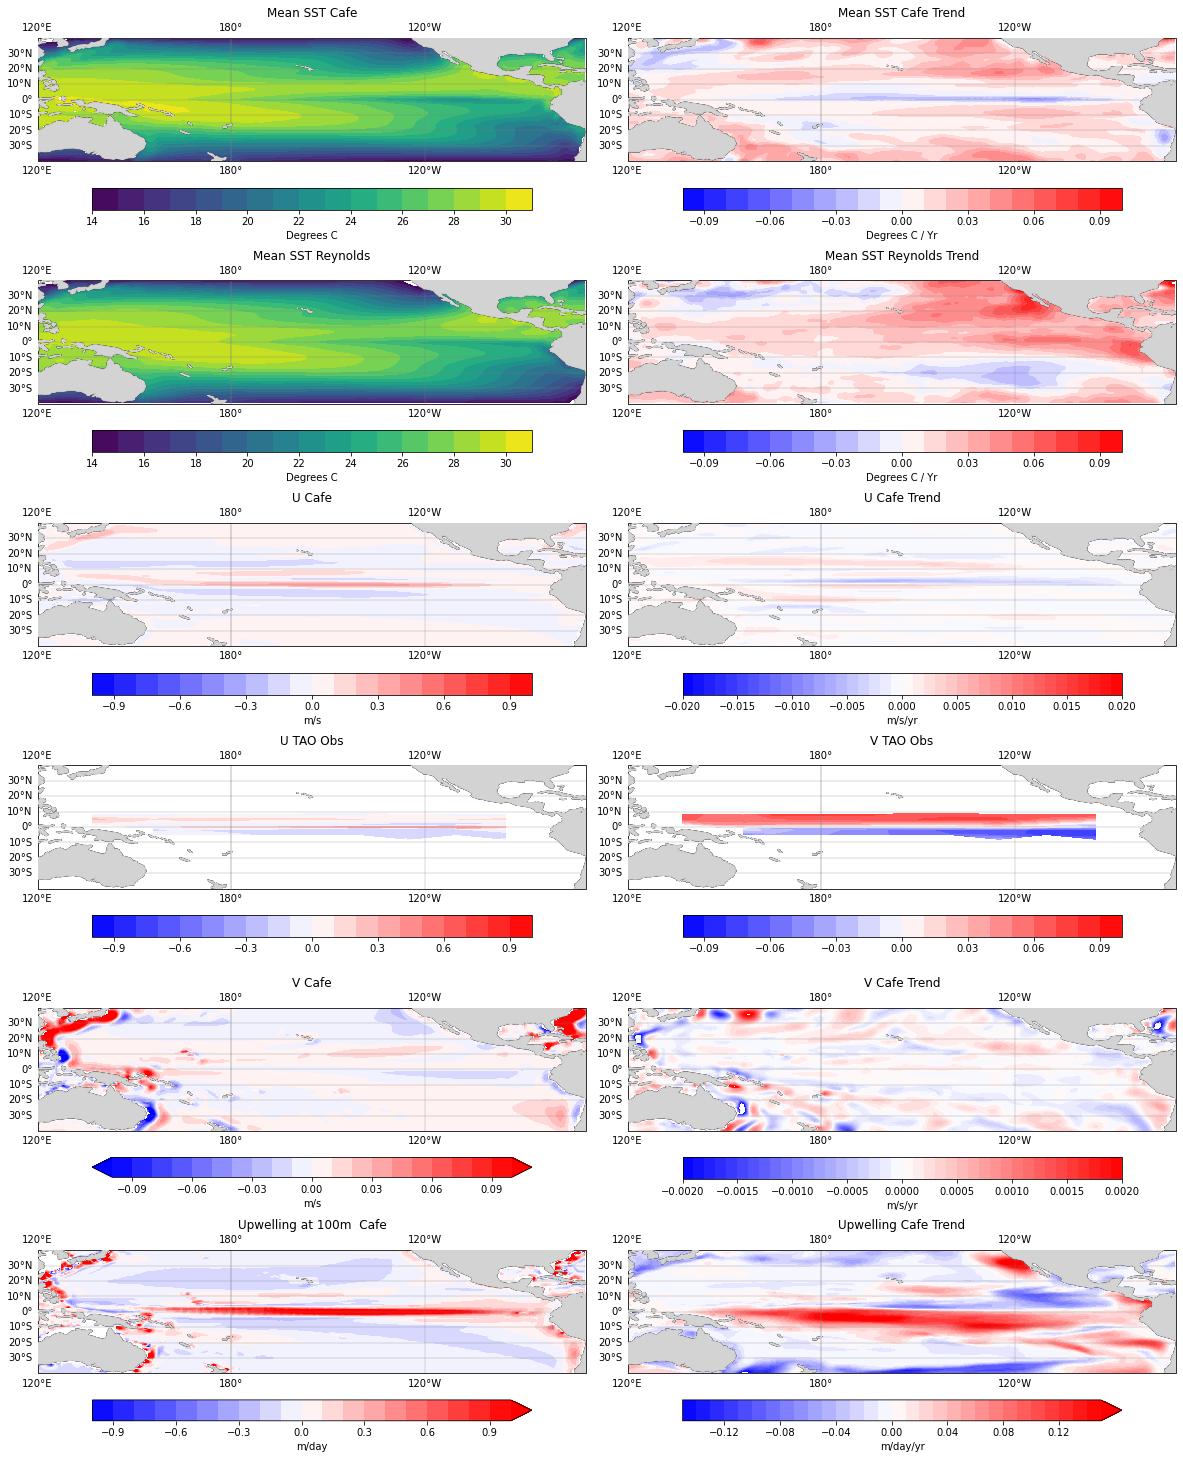

In [30]:
run_f1=True
if run_f1==True:
    sday='2000-01-01'
    eday='2020-01-01'

    # A3 is (11.69,16.53)
    #fig = plt.figure(figsize=((8.27)*1.5,11.69*1.5)) #Inches Portrait
    shrink=0.8
    fig = plt.figure(figsize=((8.27*2),(11.69*2))) #Inches Portrait

    plot_pacific_subplot(cafe_sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=721,title='Mean SST Cafe',levels=np.arange(14,32,1),units='Degrees C',cmap='viridis',shrink=shrink)
    plot_pacific_subplot(cafe_sst_trend.mean(dim='timeperiod').sel(parameter=0),sb=722,title='Mean SST Cafe Trend',levels=np.arange(-0.1,0.11,0.01),units='Degrees C / Yr',shrink=shrink)

    plot_pacific_subplot(rey_sst.sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=723,title='Mean SST Reynolds',levels=np.arange(14,32,1),cmap='viridis',units='Degrees C',shrink=shrink)
    plot_pacific_subplot(rey_sst_trend.mean(dim='timeperiod').sel(parameter=0),sb=724,title='Mean SST Reynolds Trend',levels=np.arange(-0.1,0.11,0.01),units='Degrees C / Yr',shrink=shrink)

    plot_pacific_subplot(cafe_u.chunk({'st_ocean':-1}).mean('st_ocean').rename({'lon_x':'lon','lat_x':'lat'}).sel(time=slice(sday,eday)).mean(dim='time'),sb=725,title='U Cafe',units='m/s',levels=np.arange(-1,1.1,0.1),shrink=shrink)
    plot_pacific_subplot(cafe_u_trend.mean(dim='timeperiod').sel(parameter=0).rename({'lon_x':'lon','lat_x':'lat'}),sb=726,title='U Cafe Trend',units='m/s/yr',levels=np.arange(-0.02,0.021,0.001),shrink=shrink)

    plot_pacific_subplot(obs_current.U_320.interpolate_na(dim='lat').interpolate_na(dim='lon').mean(dim=['depth','time']),sb=727,levels=np.arange(-1,1.1,0.1),cmap='bwr',title='U TAO Obs',shrink=shrink,small_plot=False)
    plot_pacific_subplot(obs_current.V_321.interpolate_na(dim='lat').interpolate_na(dim='lon').mean(dim=['depth','time']),cmap='bwr',levels=np.arange(-0.1,0.11,0.01),title='V TAO Obs',sb=[7,2,8],shrink=shrink,small_plot=False)


    plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=729,title='V Cafe',units='m/s',levels=np.arange(-0.1,0.11,0.01),extend='both',shrink=shrink)
    plot_pacific_subplot(cafe_v_trend.mean(dim='timeperiod').sel(parameter=0).rename({'lon_x':'lon','lat_x':'lat'}),sb=[7,2,10],title='V Cafe Trend',units='m/s/yr',levels=np.arange(-0.002,0.0021,0.0001),shrink=shrink)


    plot_pacific_subplot(upwelling_cafe.sel(time=slice(sday,eday)).mean(dim='time')*60*60*24,sb=[7,2,11],title='Upwelling at 100m  Cafe',units='m/day',levels=np.arange(-1,1.1,0.1),extend='max',shrink=shrink)
    plot_pacific_subplot(upwelling_cafe_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*24,sb=[7,2,12],title='Upwelling Cafe Trend',units='m/day/yr',levels=np.arange(-0.15,0.16,0.01),extend='max',shrink=shrink)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0)


In [31]:
#(land_co2_trend.mean(dim='timeperiod').sel(parameter=0)*1000).plot()

In [32]:
run_f2=True
shrink=0.8

In [22]:
cluster

# Figure 3 ? 2 for now.

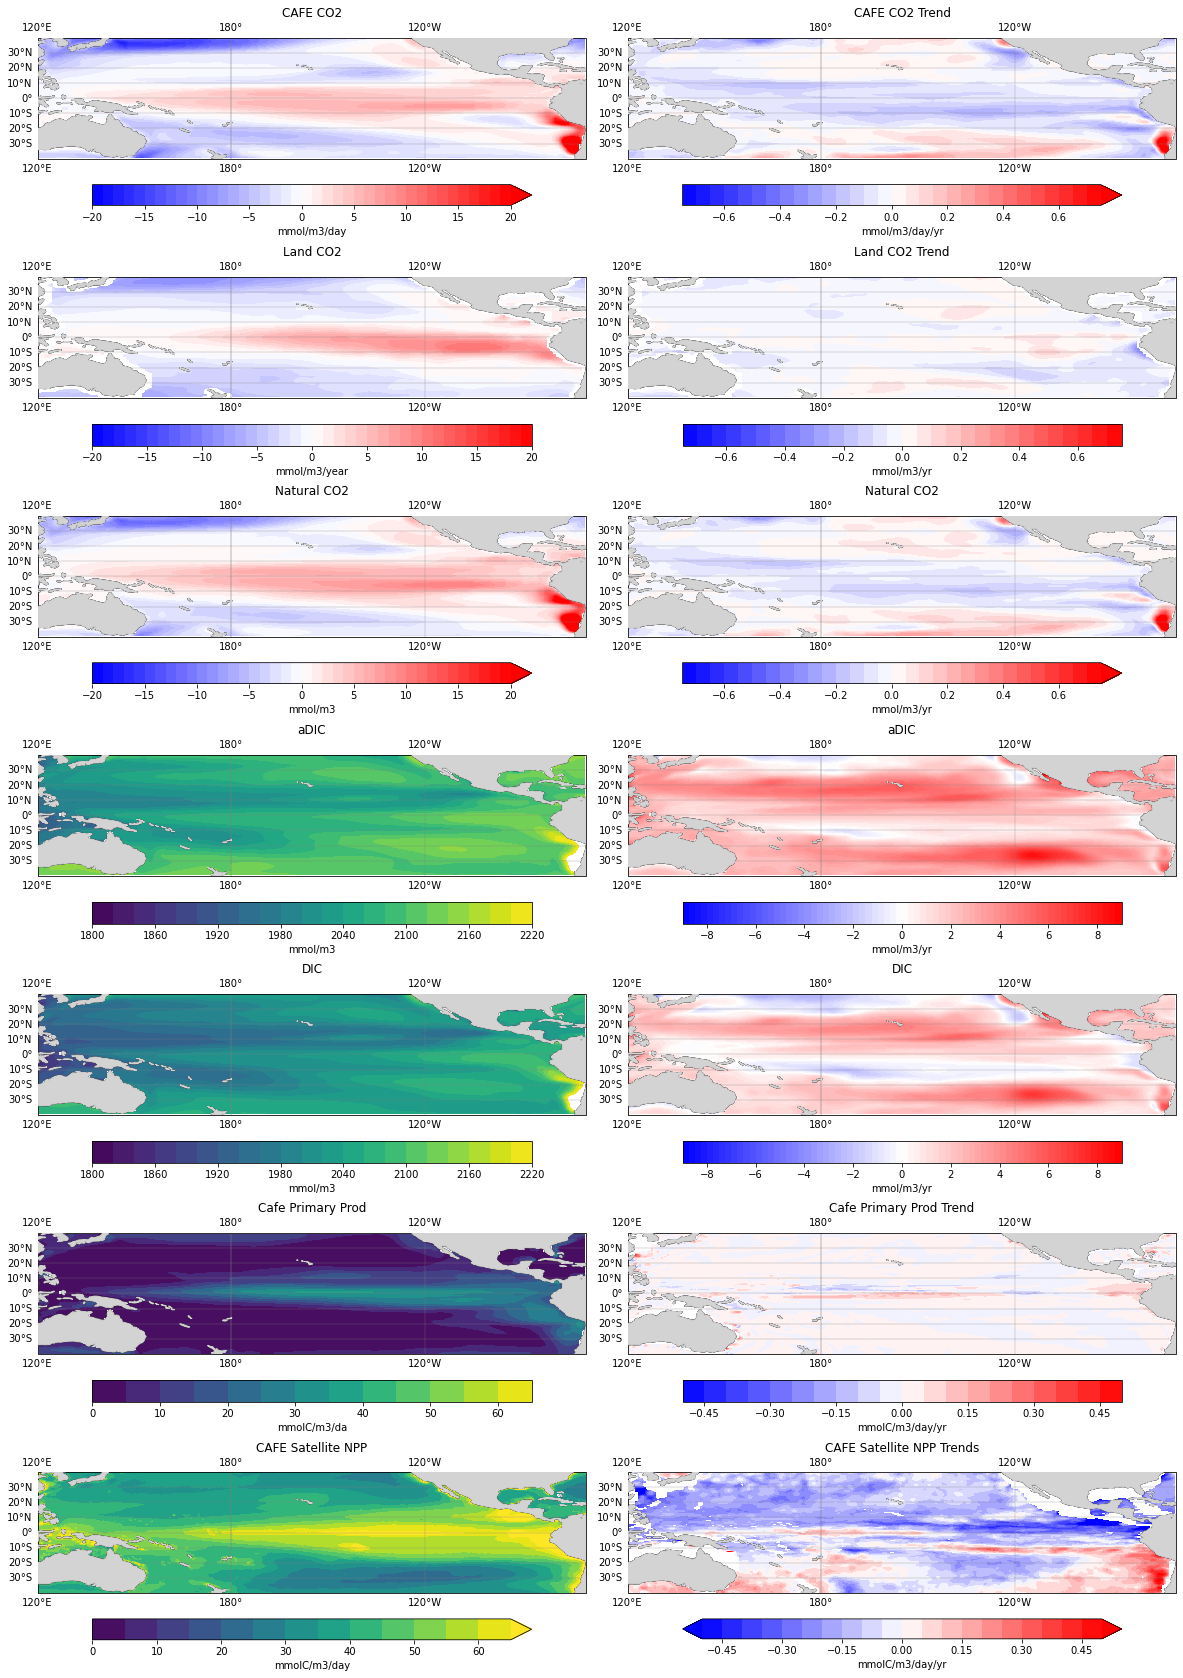

In [34]:
if run_f2==True:
    sday='2000-01-01'
    eday='2020-01-01'
    fig = plt.figure(figsize=((8.27*2),11.69*2)) #Inches Portrait

    plot_pacific_subplot(cafe_co2.sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=721,title='CAFE CO2',levels=np.arange(-20,21,1),units='mmol/m3/day',shrink=shrink,extend='max')
    plot_pacific_subplot(cafe_co2_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=722,title='CAFE CO2 Trend',levels=np.arange(-0.75,0.8,0.05),units='mmol/m3/day/yr',shrink=shrink,extend='max')

    plot_pacific_subplot((land_co2).sel(time=slice(sday,eday)).mean(dim='time'),sb=723,title='Land CO2',levels=np.arange(-20,21,1),units='mmol/m3/year',shrink=shrink)
    plot_pacific_subplot(land_co2_trend.mean(dim='timeperiod').sel(parameter=0)*1000,sb=724,title='Land CO2 Trend',levels=np.arange(-0.75,0.8,0.05),units='mmol/m3/yr',shrink=shrink)

    plot_pacific_subplot(cafe_co2_natural.sel(time=slice(sday,eday)).mean(dim='time')*60*60*-24,sb=725,title='Natural CO2',levels=np.arange(-20,21,1),units='mmol/m3',extend='max',shrink=shrink)
    plot_pacific_subplot(cafe_co2_natural_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*-24,sb=726,title='Natural CO2',levels=np.arange(-0.75,0.8,0.05),units='mmol/m3/yr',extend='max',shrink=shrink)

    plot_pacific_subplot(adic_cafe.sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=727,title='aDIC',levels=np.arange(1800,2240,20),units='mmol/m3',cmap='viridis',shrink=shrink)
    plot_pacific_subplot(adic_mean_depth_trend.mean(dim='timeperiod').sel(parameter=0),sb=728,title='aDIC',levels=np.arange(-9,9.25,0.25),units='mmol/m3/yr',shrink=shrink)#,levels=np.arange(-0.025,0.025,0.0025))

    plot_pacific_subplot(dic_cafe.sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=729,title='DIC',levels=np.arange(1800,2240,20),units='mmol/m3',cmap='viridis',shrink=shrink)
    plot_pacific_subplot(dic_mean_depth_trend.mean(dim='timeperiod').sel(parameter=0),sb=[7,2,10],title='DIC',levels=np.arange(-9,9.25,0.25),units='mmol/m3/yr',shrink=shrink)


    plot_pacific_subplot(cafe_pprod.sel(time=slice(sday,eday)).mean(dim='time')*60*60*24*6.625 ,sb=[7,2,11],title='Cafe Primary Prod',units='mmolC/m3/da',cmap='viridis',levels=np.arange(0,70,5),shrink=shrink)
    plot_pacific_subplot(cafe_pprod_trend.mean(dim='timeperiod').sel(parameter=0)*60*60*24*6.625 ,sb=[7,2,12],title='Cafe Primary Prod Trend',units='mmolC/m3/day/yr',levels=np.arange(-0.5,0.55,0.05),shrink=shrink)

    plot_pacific_subplot(npp.sel(time=slice(sday,eday)).mean(dim='time')/12,sb=[7,2,13],title='CAFE Satellite NPP',units='mmolC/m3/day',cmap='viridis',levels=np.arange(0,70,5),extend='max',shrink=shrink)#,remap=True)
    plot_pacific_subplot(npp_cafe_trend.mean(dim='timeperiod').sel(parameter=0)/12,sb=[7,2,14],title='CAFE Satellite NPP Trends',units='mmolC/m3/day/yr',levels=np.arange(-0.5,0.55,0.05),extend='both',shrink=shrink)#,remap=True)
    #plot_pacific_subplot(xarray_get_trend(npp.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=[7,2,14],title='CAFE Satellite NPP Trends',units='mmol/m3/yr')

    plt.tight_layout()
    #plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=527,title='V Cafe')
    #plot_pacific_subplot(xarray_get_trend(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday))).sel(parameter=0),sb=528,title='V Cafe')


    #plot_pacific_subplot(upwelling.sel(time=slice(sday,eday)).mean(dim='time'),sb=529,title='Upwelling Cafe')
    #plot_pacific_subplot(xarray_get_trend(upwelling.sel(time=slice(sday,eday))).sel(parameter=0),sb=[5,2,10],title='Upwelling Cafe')

In [35]:

#deseasonaliser(xarray_detrend(cafe_co2,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(cafe_co2_natural,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
#deseasonaliser(xarray_detrend(land_co2,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')

## Interannual Variability

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_tr

ValueError: dimension time on 1th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

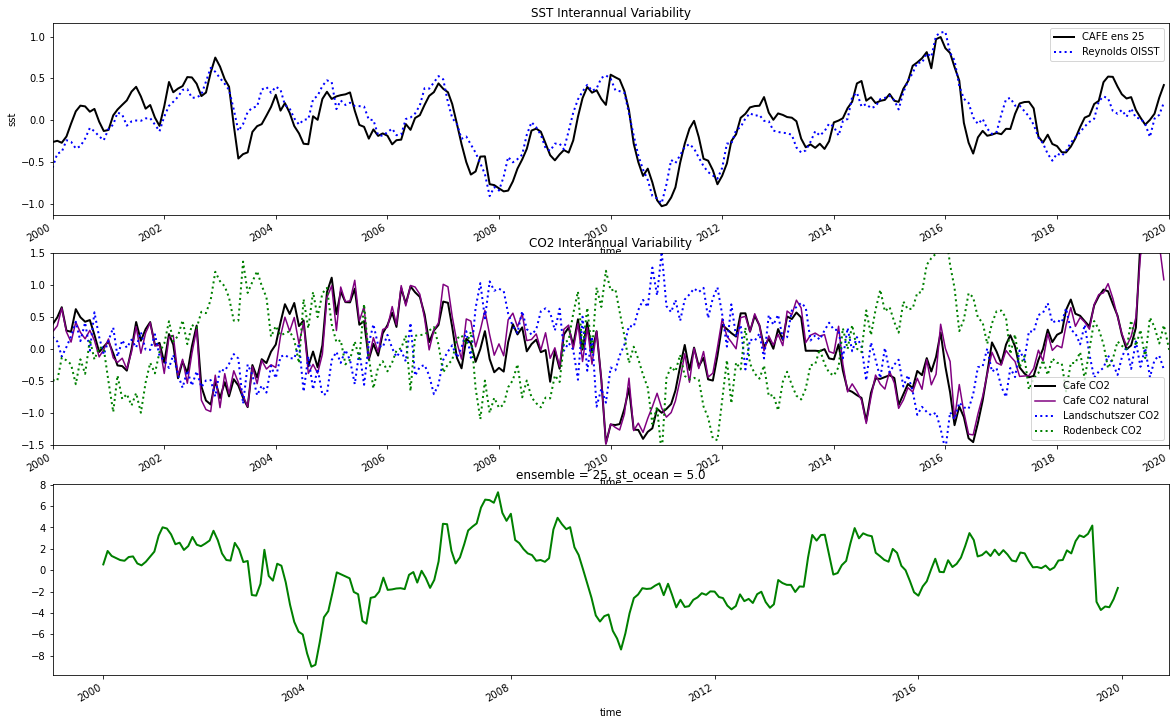

In [28]:
# Interannual Variability?
plt.figure(figsize=(20,12))
plt.subplot(311)
deseasonaliser(xarray_detrend(cafe_sst.sel(lat=slice(-10,10),time=slice('2000','2020')),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(rey_sst.sel(lat=slice(-10,10),time=slice('2000','2020')),keep_intercept_values=False)).mean(dim=['lat','lon']).sst.plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','Reynolds OISST'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Interannual Variability')

plt.subplot(312)
deseasonaliser(xarray_detrend(cafe_co2.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(cafe_co2_natural.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
deseasonaliser(xarray_detrend(land_co2.sel(lat=slice(-10,10),time=slice('2000','2020')),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_rodenbeck.sel(lat=slice(-10,10),time=slice('2000','2020'))*-1,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe CO2','Cafe CO2 natural','Landschutszer CO2','Rodenbeck CO2'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.ylim([-1.5,1.5])
plt.title('CO2 Interannual Variability')

plt.subplot(313)
#deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
deseasonaliser(xarray_detrend(cafe_pprod.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*24*6.625,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(npp.sel(lat=slice(-10,10),time=slice('2000','2020'))/12,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE Gross Primary Prod','Satellite NPP'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Interannual Variability')
plt.tight_layout()

In [52]:
#(cafe_pprod.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*24*6.625).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
#(npp.sel(lat=slice(-10,10),time=slice('2000','2020'))/12).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
#plt.legend(['Cafe GPP','Satellite NPP'])

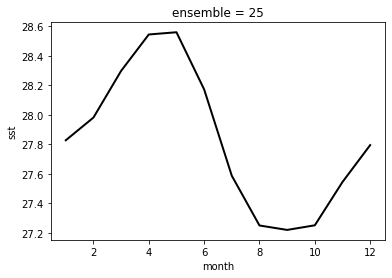

In [25]:
(cafe_sst.sel(lat=slice(-10,10),time=slice('2000','2020'))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='k',linewidth=2)

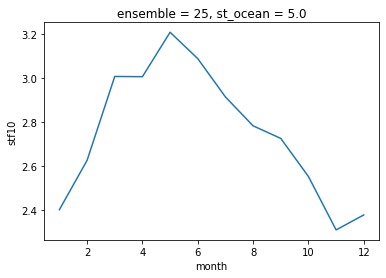

In [33]:
#((cafe_co2.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24)).mean(dim=['lat','lon']).groupby('time.month').mean().plot()

In [ ]:
# Seasonal Variability? 
plt.figure(figsize=(20,12))
plt.subplot(311)
((cafe_sst.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
((rey_sst.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).sst.groupby('time.month').mean().plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','Reynolds OISST'])
#plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Seasonality')

plt.subplot(312)
((cafe_co2.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='k',linewidth=2)
((cafe_co2_natural.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*-24)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='purple')
((land_co2.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='b',linewidth=2,linestyle=':')
((co2_rodenbeck.sel(lat=slice(-10,10),time=slice('2000','2020')))).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe CO2','Cafe CO2 natural','Landschutszer CO2','Rodenbeck CO2'])
#plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
#plt.ylim([-1.5,1.5])
plt.title('CO2 Seasonality')

plt.subplot(313)
#deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
#deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
((cafe_pprod.sel(lat=slice(-10,10),time=slice('2000','2020'))*60*60*24*6.625)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='g',linewidth=2)
((npp.sel(lat=slice(-10,10),time=slice('2000','2020'))/12)).mean(dim=['lat','lon']).groupby('time.month').mean().plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE Gross Primary Prod','Satellite NPP'])
#plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Seasonality')
plt.tight_layout()

# Figure 2: EUC Overview

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)


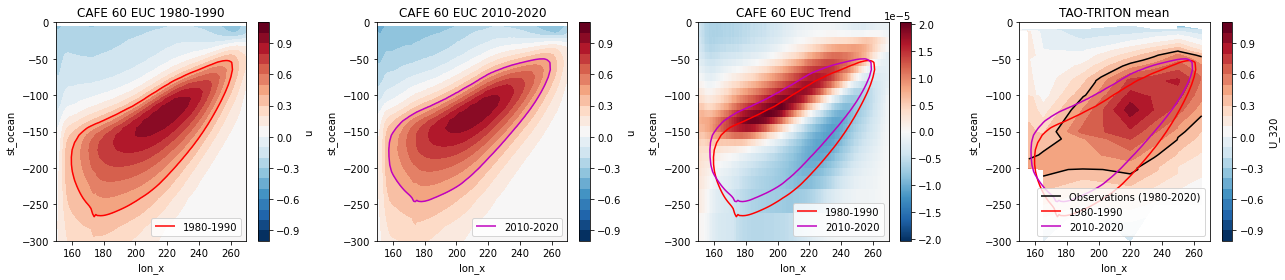

In [30]:
contour_level=0.4
plt.figure(figsize=(18,4))


plt.subplot(141)
cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('1980-1990')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC 1980-1990')


plt.subplot(142)
cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')
plt.xlim([150,270])
plt.ylim([-300,0])
cafe10.collections[0].set_label('2010-2020')
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC 2010-2020')



plt.subplot(143)
xarray_get_trend(cafe_u.sel(lat_x=0,method='nearest')).sel(parameter=0).plot()
#cafe_u.sel(lat_x=0,method='nearest').mean(dim='time').plot.contour(levels=[contour_level])
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

cafe80.collections[0].set_label('1980-1990')
cafe10.collections[0].set_label('2010-2020')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Trend')


plt.subplot(144)
euc_obs=obs_current.U_320.sel(lat=slice(-3,3)).mean(dim='lat').interpolate_na('depth').interpolate_na('lon')#.mean(dim=['time']).plot()
euc_obs['depth']=euc_obs['depth']*-1
euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))

obs80=euc_obs.sel(time=slice('1980','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='k',label='Observations (1980-2020)')
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe10=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contour(levels=[contour_level],colors='m')

obs80.collections[0].set_label('Observations (1980-2020)')
cafe80.collections[0].set_label('1980-1990')
cafe10.collections[0].set_label('2010-2020')
plt.legend(loc='lower right')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.title('TAO-TRITON mean')
plt.tight_layout()

How about including ENSO breakdown?

Text(0.5, 1.0, 'CAFE 60 EUC Neutral')

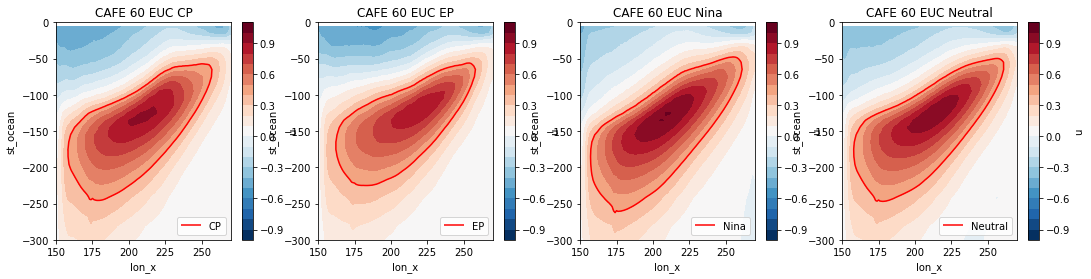

In [37]:
contour_level=0.4
plt.figure(figsize=(18,4))


plt.subplot(141)
cafe_u.sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('CP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC CP')



plt.subplot(142)
cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('EP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC EP')


plt.subplot(143)
cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('Nina')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Nina')

plt.subplot(144)
cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('Neutral')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Neutral')



In [33]:
#euc_obs.sel(time=slice('2000','2025')).mean(dim='time').plot.contourf()

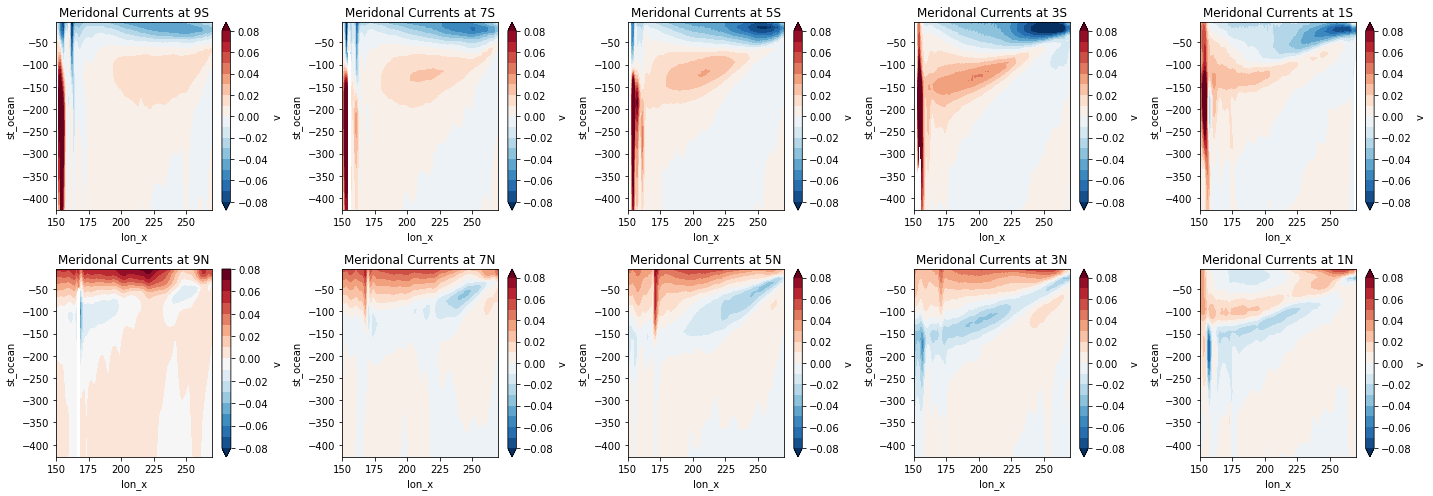

In [34]:
plt.figure(figsize=(15,7))
plt.subplot(251)
levs=np.arange(-0.08,0.081,0.01)

cafe_v.sel(lat_x=-9,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.title('Meridonal Currents at 9S')
plt.xlim([150,270])

plt.subplot(252)
cafe_v.sel(lat_x=-7,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.title('Meridonal Currents at 7S')
plt.xlim([150,270])

plt.subplot(253)
cafe_v.sel(lat_x=-5,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 5S')

plt.subplot(254)
cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 3S')

plt.subplot(255)
cafe_v.sel(lat_x=-1,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 1S')

plt.subplot(256)
cafe_v.sel(lat_x=9,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 9N')

plt.subplot(257)
cafe_v.sel(lat_x=7,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 7N')

plt.subplot(258)
cafe_v.sel(lat_x=5,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 5N')

plt.subplot(259)
cafe_v.sel(lat_x=3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 3N')

plt.subplot(2,5,10)
cafe_v.sel(lat_x=1,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal Currents at 1N')

plt.tight_layout()




#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [16]:
dic_tx_v.sel(lat=-9,method='nearest')

<xarray.Dataset>
Dimensions:                        (st_ocean: 26, lon: 170)
Coordinates:
    ensemble                       int32 ...
  * st_ocean                       (st_ocean) float64 -5.0 -15.0 ... -427.3
  * lon                            (lon) float64 120.5 121.5 ... 288.5 289.5
    lat                            float64 -8.833
Data variables:
    __xarray_dataarray_variable__  (st_ocean, lon) float32 20.45 -22.42 ... nan

In [15]:
def get_area(dat,cs):
    #https://stackoverflow.com/a/70710241/9965678
    areaHold=[]
    for i in range(len(cs.collections)):
        cont = cs.collections[i]
        vs = cont.get_paths()
        contour_data=0
        for contour in vs:
            x=contour.vertices[:,0]
            y=contour.vertices[:,1]
            contour_data+=dat.sel(st_ocean=np.unique(y),lon=np.unique(x),method='nearest').sum().values#.drop_duplicates('lon')#.drop_duplicates('st_ocean')#.mean().values
            print(contour_data)#.mean())
            #area+=0.5*np.mean(y[:-1]*np.diff(x) - x[:-1]*np.diff(y))
            #print(len(vs))
            #print(area)
            #area=np.abs(area)
        areaHold.append(contour_data)#/len(vs))
    return areaHold

In [44]:
def xarray_posneg_calc(ds,cutoff=0,mean=True,printer=True):
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(np.array(res))
    return np.array(res)

In [38]:

np.array(asum).round(2)

array([ 74511.46, -52333.81], dtype=float32)

In [104]:
cs.collections[0].get_paths()[0].vertices[:,0]

[ 31.53257  -28.519789]
[ 39.009384 -25.1067  ]
[ 37.561237 -28.312778]
[ 29.582212 -32.80647 ]
[ 40.89438 -37.56302]
[ 35.833797 -39.38377 ]
[ 38.092484 -38.785175]
[ 54.498196 -35.799538]


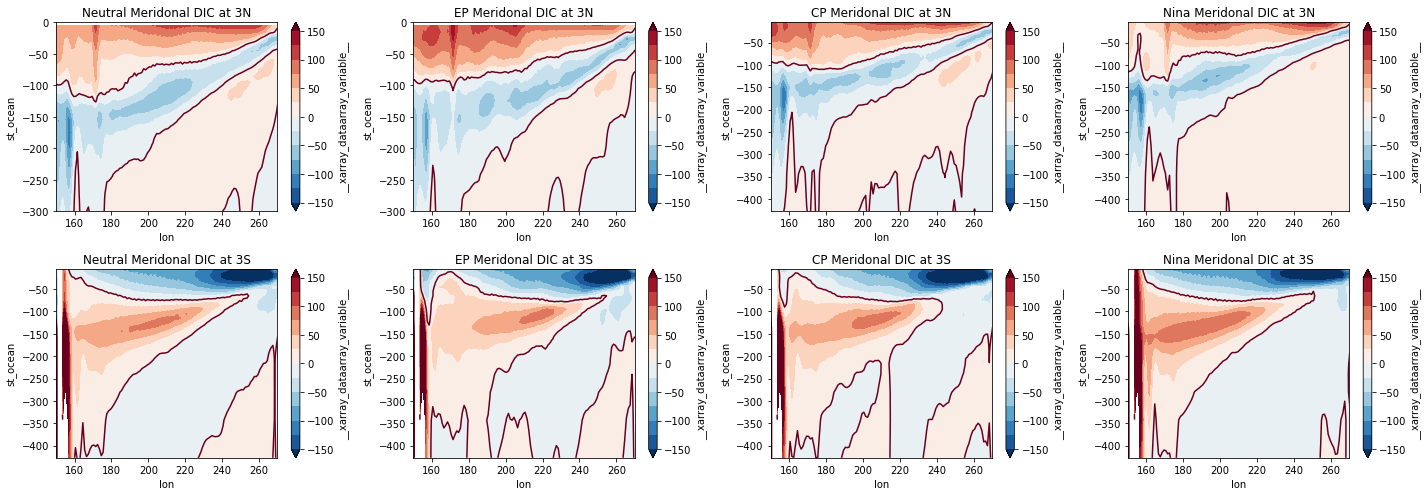

In [62]:
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-150,175,25)
contour=[0]#60,-60]
lat=3
plt.subplot(241)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
cs=dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [1]:
#(asum1[0]
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-150,175,25)
contour=[0]#60,-60]
lat=3
plt.subplot(241)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
cs=dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))/1000)*12

NameError: name 'plt' is not defined

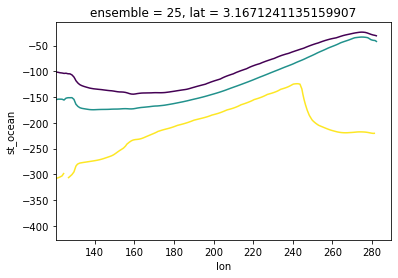

In [20]:
#(cafe_potential_density).sel(lat=3,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf()
(cafe_potential_density).sel(lat=3,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3])

In [65]:
#anth DIC MEAN
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-2.5,2.75,0.25)
contour=[0]#60,-60]
lat=3
plt.subplot(241)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
#density.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf()
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(244)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

lat=-3
plt.subplot(245)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(246)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(247)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(248)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [65]:
#anth DIC EUC CROSS SECTIONS 

levs=np.arange(-30,32,2)
contour=[0]#60,-60]
lon=180
lslice=slice(-3,3)

lons=[160,250]
for lon in lons:
    plt.figure(figsize=(20,4))
    #plt.subplot(251)
    plt.subplot(141)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=neutral_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=neutral_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
    asum=xarray_posneg_calc(anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=neutral_events,lat=lslice).mean(dim='time'))
    
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    #print(asum)
    plt.title(f'Neutral Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])

    plt.subplot(142)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=ep_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=ep_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
    asum=xarray_posneg_calc(anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=ep_events,lat=lslice).mean(dim='time'))
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    #print(asum)
    plt.title(f'EP Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])

    plt.subplot(143)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=cp_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=cp_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
    asum=xarray_posneg_calc(anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=cp_events,lat=lslice).mean(dim='time'))
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    plt.title(f'CP Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])

    plt.subplot(144)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=nina_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
    anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=nina_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
    asum=xarray_posneg_calc(anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=nina_events,lat=lslice).mean(dim='time'))
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    plt.title(f'Nina Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])
    
    
    plt.tight_layout()
    plt.show()
    # Mmol DIC/m2/s
    #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [65]:
d1=1023
d2=1024.5
d3=1026.3

In [18]:
1023

1046529

## Start Estimating the ENSO transport through EUC

Get sum area integration for AnthDIC flow in molC/s through each of the sides of the box.

In [230]:
def xarray_posneg_calc(ds,cutoff=0,mean=False,printer=True):
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        #print(np.array(res))
        #print((res[0]/-grid_multiplier_lon.sum().values,(res[1]/-grid_multiplier_lon.sum().values)))
        # PRINTING Tonne/s
        # assumin mmol/s input 
        print(np.round(((res[0]/1000/1000)*12),0),#*((grid_multiplier_lon.T*-1).sum().values),
              np.round(((res[1]/1000/1000)*12),0),
              np.round((abs(res[0]/1000/1000)*12)-abs((res[1]/1000/1000)*12),0))#*(grid_multiplier_lon.T*-1).sum().values))
        
    return np.array(res)

In [89]:
grid_multiplier_lon=grid_rg.depth_lon_m2
grid_multiplier_lon=grid_multiplier_lon.rename({'lon_m':'lon','depth_diff':'st_ocean'})
grid_multiplier_lon['lon']=grid_rg.lon
grid_multiplier_lon['st_ocean']=grid_rg.depth.values

grid_multiplier_lat=grid_rg.depth_lat_m2
grid_multiplier_lat=grid_multiplier_lat.rename({'lat_m':'lat','depth_diff':'st_ocean'})
grid_multiplier_lat['lat']=grid_rg.lat
grid_multiplier_lat['st_ocean']=grid_rg.depth.values


In [72]:
#grid_multiplier_lat
#grid_multiplier_lon

<xarray.DataArray 'depth_lat_m2' (lat: 140, st_ocean: 26)>
array([[ 541637.22660378, 1083274.45320755, 1083274.45320755, ...,
        4271537.15844054, 6767185.88840174, 9106556.87303441],
       [ 544451.81669486, 1088903.63338972, 1088903.63338972, ...,
        4293733.98238344, 6802351.22307684, 9153878.62914679],
       [ 547110.66901559, 1094221.33803119, 1094221.33803119, ...,
        4314702.60479153, 6835570.77856611, 9198581.9631986 ],
       ...,
       [ 535333.00678362, 1070666.01356723, 1070666.01356723, ...,
        4221819.91617187, 6688421.31073068, 9000563.90668611],
       [ 530292.55796197, 1060585.11592395, 1060585.11592395, ...,
        4182069.20595599, 6625446.21880264, 8915818.74589332],
       [ 530292.55796197, 1060585.11592395, 1060585.11592395, ...,
        4182069.20595599, 6625446.21880264, 8915818.74589332]])
Coordinates:
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 35.0 ... 241.3 280.8 343.3 427.3

In [28]:
#grid_lat_multiplier=grid_rg.sel(lat=3,method='nearest')[['depth_m2']]
#grid_lat_multiplier=grid_lat_multiplier.rename({'depth_diff':'st_ocean'})
#grid_lat_multiplier['st_ocean']=grid.depth
#grid_lat_multiplier

<xarray.Dataset>
Dimensions:   (lon: 170, st_ocean: 26, depth: 26)
Coordinates:
    lat       float64 3.5
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    m2        (lon) float64 1.232e+10 1.232e+10 ... 1.232e+10 1.232e+10
    st_ocean  (depth) float64 5.0 15.0 25.0 35.0 ... 241.3 280.8 343.3 427.3
  * depth     (depth) float64 5.0 15.0 25.0 35.0 ... 241.3 280.8 343.3 427.3
Data variables:
    depth_m2  (lon, st_ocean) float64 2.482e+05 3.51e+05 ... 8.773e+05 1.018e+06

In [36]:
# Density Check
(cafe_potential_density).sel(lon=slice(160,250)).sel(time=nina_events).mean(dim=['time','lon']).plot.contourf(levels=np.arange(1020,1030,1))#(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
(cafe_potential_density).sel(lon=slice(160,250)).sel(time=nina_events).mean(dim=['time','lon']).plot.contour(levels=[1023,1024.5,1026.3],colors='k',linestyles=":",linewidths=3)

In [36]:
#grid_multiplier.depth_m2#.depth_m2#.coords

<xarray.DataArray 'depth_m2' (lon: 170, st_ocean: 26)>
array([[ 248195.36080705,  351001.24537142,  351001.24537142, ...,
         696997.95045608,  877290.56740215, 1017692.34738564],
       [ 248195.36080705,  351001.24537142,  351001.24537142, ...,
         696997.95045608,  877290.56740215, 1017692.34738564],
       [ 248195.36080705,  351001.24537142,  351001.24537142, ...,
         696997.95045608,  877290.56740215, 1017692.34738564],
       ...,
       [ 248195.36080705,  351001.24537142,  351001.24537142, ...,
         696997.95045608,  877290.56740215, 1017692.34738564],
       [ 248195.36080705,  351001.24537142,  351001.24537142, ...,
         696997.95045608,  877290.56740215, 1017692.34738564],
       [ 248195.36080705,  351001.24537142,  351001.24537142, ...,
         696997.95045608,  877290.56740215, 1017692.34738564]])
Coordinates:
    lat      float64 3.5
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    m2       (lon) float64 1.232e+10 1.232e+10 1.232e+10 ... 1.232e+10 1.232e+10
Dimensions without coordinates: st_ocean

In [102]:
asum[0]/-grid_multiplier_lon.sum()

<xarray.DataArray 'depth_lon_m2' ()>
array(0.2288018)

In [134]:
grid#*grid_multiplier_lon

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 170)
Coordinates:
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 36.5 37.5 38.5 39.5
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    area     (lat, lon) float64 9.524e+09 9.524e+09 ... 9.524e+09 9.524e+09
Data variables:
    m2       (lat, lon) float64 9.524e+09 9.524e+09 ... 9.524e+09 9.524e+09

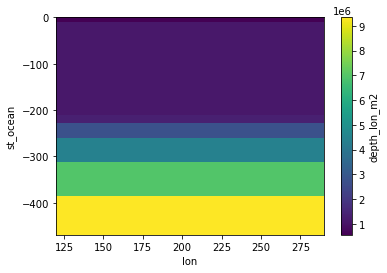

In [132]:
((grid_multiplier_lon*-1).T).plot()

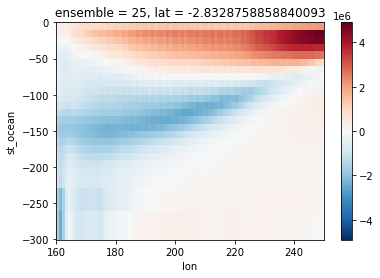

12683.0 -13300.0 -617.0


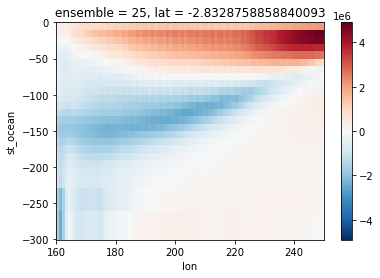

In [236]:
lat=-3
adic_tx_n=(grid_multiplier_lon*anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-300),lon=slice(160,250))).sel(time=neutral_events).mean(dim='time')
# So this is 

adic_tx_n.T.plot()
plt.show()
dat=(adic_tx_n.T)
dat.plot()
asum=xarray_posneg_calc(dat)

<xarray.DataArray 'depth_lon_m2' (lon: 170, st_ocean: 26)>
array([[ 555500.        , 1111000.        , 1111000.        , ...,
        4380863.74969482, 6940386.62109375, 9339631.94274902],
       [ 555500.        , 1111000.        , 1111000.        , ...,
        4380863.74969482, 6940386.62109375, 9339631.94274902],
       [ 555500.        , 1111000.        , 1111000.        , ...,
        4380863.74969482, 6940386.62109375, 9339631.94274902],
       ...,
       [ 555500.        , 1111000.        , 1111000.        , ...,
        4380863.74969482, 6940386.62109375, 9339631.94274902],
       [ 555500.        , 1111000.        , 1111000.        , ...,
        4380863.74969482, 6940386.62109375, 9339631.94274902],
       [ 555500.        , 1111000.        , 1111000.        , ...,
        4380863.74969482, 6940386.62109375, 9339631.94274902]])
Coordinates:
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3

In [171]:
(dat.where(dat>0).sum())#(grid_multiplier_lon*-1)).mean()

<xarray.DataArray ()>
array(8.13783286e+08)
Coordinates:
    ensemble  int32 25
    lat       float64 -2.833

19305.0 -23492.0 -4187.0
19963.0 -28339.0 -8375.0
20217.0 -27493.0 -7276.0
19406.0 -23438.0 -4031.0
21386.0 -27246.0 -5860.0
21921.0 -26486.0 -4565.0
21332.0 -27035.0 -5703.0
22159.0 -30404.0 -8245.0


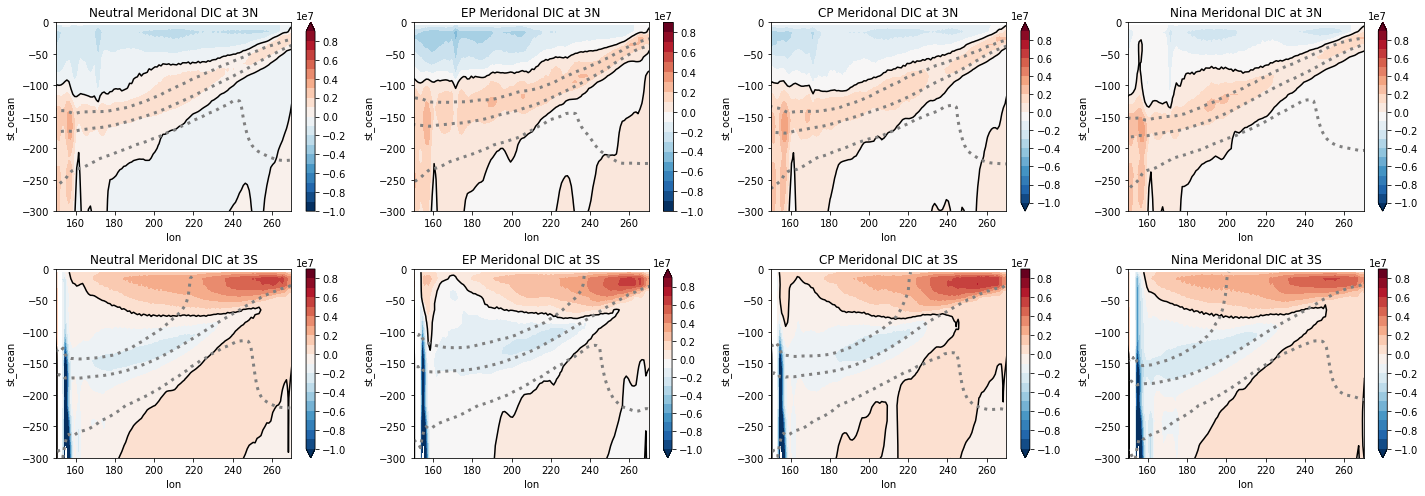

In [237]:
#anth DIC with GRID???
# SIde Budget


#grid_multiplier_lat
#grid_multiplier_lon

plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-1e7,1e7,1e6)
contour=[0]#60,-60]
lat=3

adic_tx_n=(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

plt.subplot(241)        
adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=neutral_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=ep_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=cp_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(244)
adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=nina_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

lat=-3
adic_tx_s=(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T#.load()

plt.subplot(245)
adic_tx_s.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=neutral_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(246)
adic_tx_s.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=ep_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(247)
adic_tx_s.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=cp_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(248)
adic_tx_s.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=nina_events).mean(dim='time'))

(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

19305.0 -23492.0 -4187.0
19963.0 -28339.0 -8375.0
20217.0 -27493.0 -7276.0
19406.0 -23438.0 -4031.0
21386.0 -27246.0 -5860.0
21921.0 -26486.0 -4565.0
21332.0 -27035.0 -5703.0
22159.0 -30404.0 -8245.0


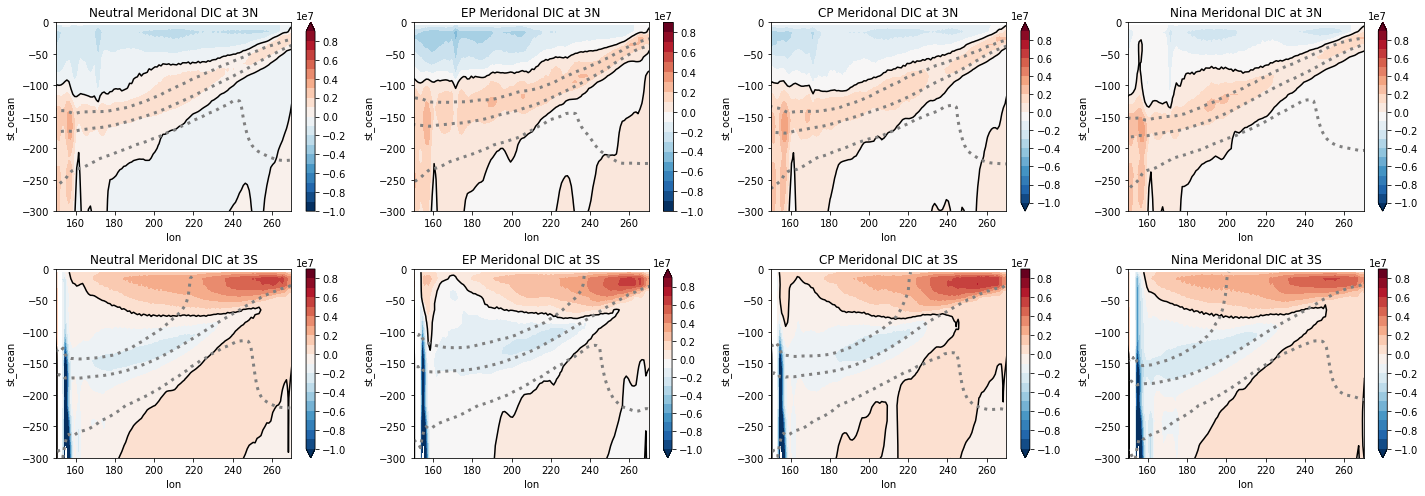

In [226]:
#anth DIC with GRID???
# SIde Budget


#grid_multiplier_lat
#grid_multiplier_lon

plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-1e7,1e7,1e6)
contour=[0]#60,-60]
lat=3

adic_tx_n=(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

plt.subplot(241)        
adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=neutral_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=ep_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=cp_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(244)
adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_n.sel(time=nina_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

lat=-3
adic_tx_s=(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T#.load()

plt.subplot(245)
adic_tx_s.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=neutral_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(246)
adic_tx_s.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=ep_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(247)
adic_tx_s.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=cp_events).mean(dim='time'))
(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(248)
adic_tx_s.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
adic_tx_s.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(adic_tx_s.sel(time=nina_events).mean(dim='time'))

(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

9548.0 -16674.0 -7126.0
10901.0 -14291.0 -3391.0
12405.0 -16166.0 -3761.0
8803.0 -16693.0 -7891.0


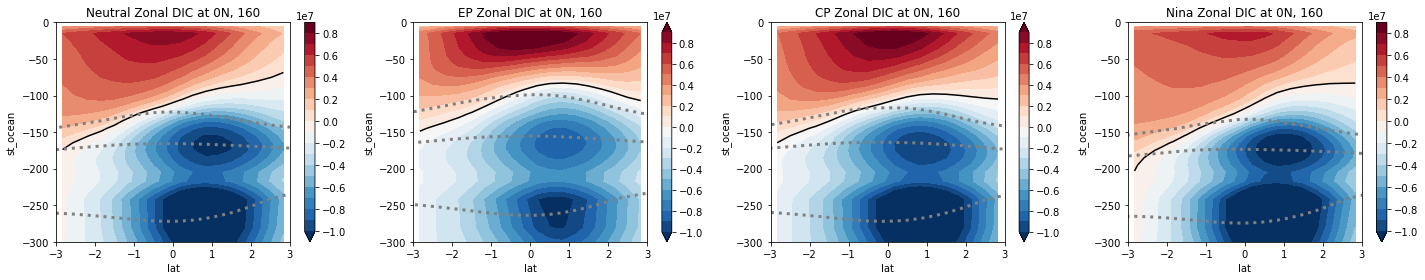

2843.0 -9205.0 -6362.0
3862.0 -8709.0 -4847.0
3641.0 -8296.0 -4655.0
2464.0 -9633.0 -7169.0


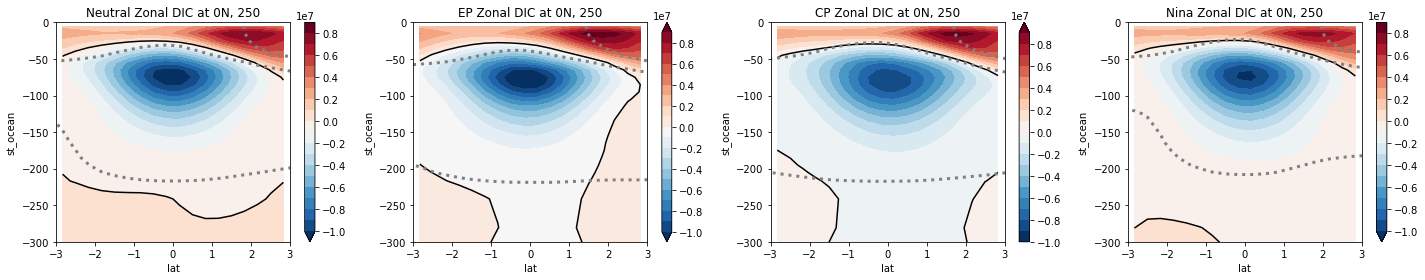

In [227]:
#anth DIC

levs=np.arange(-1e7,1e7,1e6)
contour=[0]#60,-60]
lon=180
lslice=slice(-3,3)

lons=[160,250]
for lon in lons:
    plt.figure(figsize=(20,4))
    #plt.subplot(251)
    plt.subplot(141)
    
    adic_tx_b=grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest').sel(lat=lslice)#.mean(dim='time')
    
    #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

    adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
    adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
    asum=xarray_posneg_calc(adic_tx_b.sel(time=neutral_events).mean(dim='time'))
    
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    #print(asum)
    plt.title(f'Neutral Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])

    plt.subplot(142)
    adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
    adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
    asum=xarray_posneg_calc(adic_tx_b.sel(time=ep_events).mean(dim='time'))
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    #print(asum)
    plt.title(f'EP Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])

    plt.subplot(143)
    adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
    adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
    asum=xarray_posneg_calc(adic_tx_b.sel(time=cp_events).mean(dim='time'))
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    plt.title(f'CP Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])

    plt.subplot(144)
    adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
    adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
    asum=xarray_posneg_calc(adic_tx_b.sel(time=nina_events).mean(dim='time'))
    (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
    plt.title(f'Nina Zonal DIC at 0N, {lon}')
    #plt.xlim([150,270])
    plt.ylim([-300,0])
    plt.xlim([-3,3])
    
    
    plt.tight_layout()
    plt.show()
    # Mmol DIC/m2/s
    #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

<xarray.DataArray 'm2' (lat: 140, lon: 170)>
array([[5.44928160e+09, 5.44928160e+09, 5.44928160e+09, ...,
        5.44928160e+09, 5.44928160e+09, 5.44928160e+09],
       [5.52471241e+09, 5.52471241e+09, 5.52471241e+09, ...,
        5.52471241e+09, 5.52471241e+09, 5.52471241e+09],
       [5.59892021e+09, 5.59892021e+09, 5.59892021e+09, ...,
        5.59892021e+09, 5.59892021e+09, 5.59892021e+09],
       ...,
       [5.60159222e+09, 5.60159222e+09, 5.60159222e+09, ...,
        5.60159222e+09, 5.60159222e+09, 5.60159222e+09],
       [5.52869002e+09, 5.52869002e+09, 5.52869002e+09, ...,
        5.52869002e+09, 5.52869002e+09, 5.52869002e+09],
       [5.45492957e+09, 5.45492957e+09, 5.45492957e+09, ...,
        5.45492957e+09, 5.45492957e+09, 5.45492957e+09]])
Coordinates:
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


0.0 -2414.0 -2414.0
0.0 -2349.0 -2349.0


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


0.0 -2177.0 -2177.0
0.0 -2614.0 -2614.0


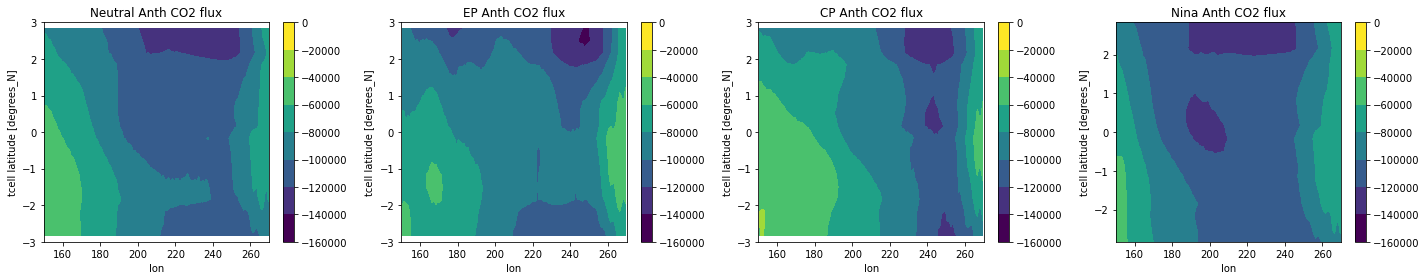

In [228]:
#anth DIC

levs=np.arange(-160000,20000,20000)
contour=[0]#60,-60]
lon=180
lslice=slice(-3,3)

#lons=[160,250]
#for lon in lons:
plt.figure(figsize=(20,4))
#plt.subplot(251)
plt.subplot(141)

aco2_flux=-cafe_co2_anth.sel(lat=lslice,lon=slice(150,270))*grid_rg.m2

#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

aco2_flux.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
aco2_flux.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(aco2_flux.sel(time=neutral_events).mean(dim='time'))

#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
#print(asum)
plt.title(f'Neutral Anth CO2 flux')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])

plt.subplot(142)
aco2_flux.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
aco2_flux.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(aco2_flux.sel(time=ep_events).mean(dim='time'))
#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
#print(asum)
plt.title(f'EP Anth CO2 flux')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])

plt.subplot(143)
aco2_flux.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
aco2_flux.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(aco2_flux.sel(time=cp_events).mean(dim='time'))
#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
plt.title(f'CP Anth CO2 flux')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])

plt.subplot(144)
aco2_flux.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
aco2_flux.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(aco2_flux.sel(time=nina_events).mean(dim='time'))
#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
plt.title(f'Nina Anth CO2 flux')
#plt.xlim([150,270])
plt.xlim([150,270])
#plt.ylim([-3,3])


plt.tight_layout()
plt.show()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

14036.0 -230.0 13805.0
15236.0 -465.0 14771.0
14739.0 -494.0 14245.0
14563.0 -257.0 14306.0


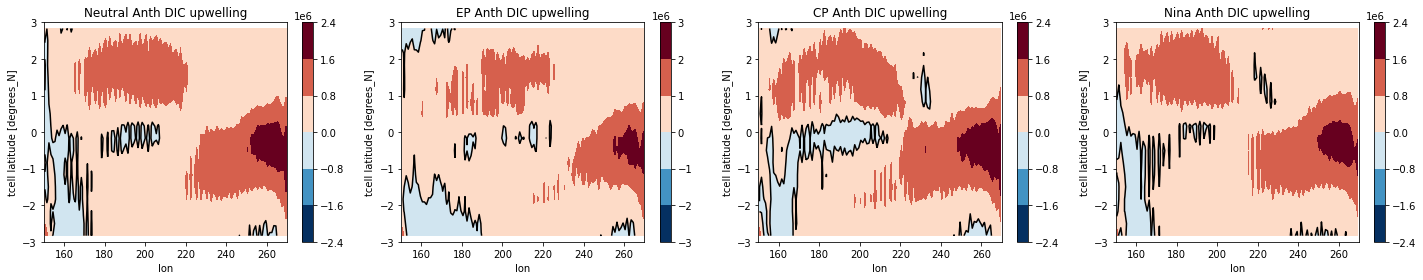

In [229]:
#anth DIC UPWELLING
levs=None#np.arange(-1e7,1e7,1e6)
contour=[0]#60,-60]
lon=180
lslice=slice(-3,3)

#lons=[160,250]
#for lon in lons:
plt.figure(figsize=(20,4))
#plt.subplot(251)
plt.subplot(141)

#aco2_flux=-cafe_co2_anth.sel(lat=lslice,lon=slice(150,270))
upwelling_dat=anth_dic_tx_w.sel(st_ocean=300,method='nearest').sel(lat=lslice,lon=slice(150,270))*grid_rg.m2
#co2_flux=-cafe_co2_anth.sel(lat=lslice,lon=slice(150,270))*grid_rg.m2
#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).mean(dim='time'))

#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
#print(asum)
plt.title(f'Neutral Anth DIC upwelling')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])

plt.subplot(142)
upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(upwelling_dat.sel(time=ep_events).mean(dim='time'))
#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
#print(asum)
plt.title(f'EP Anth DIC upwelling')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])

plt.subplot(143)
upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(upwelling_dat.sel(time=cp_events).mean(dim='time'))
#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
plt.title(f'CP Anth DIC upwelling')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])

plt.subplot(144)
upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
asum=xarray_posneg_calc(upwelling_dat.sel(time=nina_events).mean(dim='time'))
#(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
plt.title(f'Nina Anth DIC upwelling')
#plt.xlim([150,270])
plt.xlim([150,270])
plt.ylim([-3,3])


plt.tight_layout()
plt.show()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

# END OF BOX ESTIMATE?

[ 4.2846434e-05 -4.6136238e-06]
[ 3.8021411e-05 -2.3891105e-06]
[ 4.1474395e-05 -4.0821587e-06]
[ 4.072046e-05 -5.723299e-06]


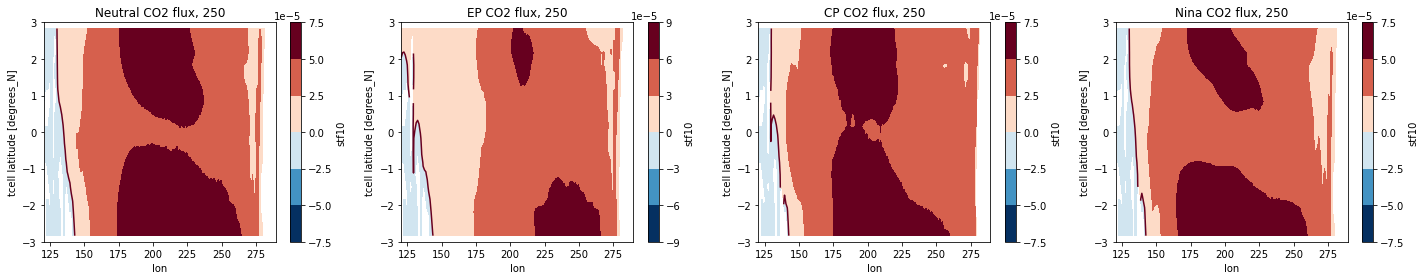

In [37]:
# Total CO2 Into Ocean
plt.figure(figsize=(20,4))
#plt.subplot(251)
contour=[0]
lslice=slice(-3,3)
levs=None#np.arange(-0.01,0.01,0.001)
plt.subplot(141)
(cafe_co2*-1).sel(time=neutral_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
(cafe_co2*-1).sel(time=neutral_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc((cafe_co2*-1).sel(time=neutral_events,lat=lslice).mean(dim='time'))
#print(asum)
plt.title(f'Neutral CO2 flux')
#plt.xlim([150,270])
#plt.ylim([-300,0])
plt.ylim([-3,3])

plt.subplot(142)
(cafe_co2*-1).sel(time=ep_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
(cafe_co2*-1).sel(time=ep_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc((cafe_co2*-1).sel(time=ep_events,lat=lslice).mean(dim='time'))
#print(asum)
plt.title(f'EP CO2 flux')

plt.ylim([-3,3])
#plt.xlim([150,270])
#plt.ylim([-300,0])


plt.subplot(143)
(cafe_co2*-1).sel(time=cp_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
(cafe_co2*-1).sel(time=cp_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc((cafe_co2*-1).sel(time=cp_events,lat=lslice).mean(dim='time'))
plt.title(f'CP CO2 flux')
plt.ylim([-3,3])
#plt.xlim([150,270])
#plt.ylim([-300,0])

plt.subplot(144)
(cafe_co2*-1).sel(time=nina_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
(cafe_co2*-1).sel(time=nina_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc((cafe_co2*-1).sel(time=nina_events,lat=lslice).mean(dim='time'))
plt.title(f'Nina CO2 flux')
plt.ylim([-3,3])
#plt.xlim([150,270])
#plt.ylim([-300,0])
plt.tight_layout()
plt.show()

In [22]:
#.sel(time=slice('2000-01-01','2020-01-01')

<xarray.DataArray '__xarray_dataarray_variable__' (time: 720, lat: 140, lon: 170)>
[17136000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
    st_ocean  float64 -5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

<xarray.DataArray 'm2' (lat: 80, lon: 170)>
array([[9.52432427e+09, 9.52432427e+09, 9.52432427e+09, ...,
        9.52432427e+09, 9.52432427e+09, 9.52432427e+09],
       [9.65989683e+09, 9.65989683e+09, 9.65989683e+09, ...,
        9.65989683e+09, 9.65989683e+09, 9.65989683e+09],
       [9.79252688e+09, 9.79252688e+09, 9.79252688e+09, ...,
        9.79252688e+09, 9.79252688e+09, 9.79252688e+09],
       ...,
       [9.79252688e+09, 9.79252688e+09, 9.79252688e+09, ...,
        9.79252688e+09, 9.79252688e+09, 9.79252688e+09],
       [9.65989683e+09, 9.65989683e+09, 9.65989683e+09, ...,
        9.65989683e+09, 9.65989683e+09, 9.65989683e+09],
       [9.52432427e+09, 9.52432427e+09, 9.52432427e+09, ...,
        9.52432427e+09, 9.52432427e+09, 9.52432427e+09]])
Coordinates:
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 36.5 37.5 38.5 39.5
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    m2       (lat, lon) float64 9.524e+09 9.524e+09 ... 9.524e+09 9.524e+09

In [25]:
grid.m2

<xarray.DataArray 'm2' (lat: 80, lon: 170)>
array([[9.52432427e+09, 9.52432427e+09, 9.52432427e+09, ...,
        9.52432427e+09, 9.52432427e+09, 9.52432427e+09],
       [9.65989683e+09, 9.65989683e+09, 9.65989683e+09, ...,
        9.65989683e+09, 9.65989683e+09, 9.65989683e+09],
       [9.79252688e+09, 9.79252688e+09, 9.79252688e+09, ...,
        9.79252688e+09, 9.79252688e+09, 9.79252688e+09],
       ...,
       [9.79252688e+09, 9.79252688e+09, 9.79252688e+09, ...,
        9.79252688e+09, 9.79252688e+09, 9.79252688e+09],
       [9.65989683e+09, 9.65989683e+09, 9.65989683e+09, ...,
        9.65989683e+09, 9.65989683e+09, 9.65989683e+09],
       [9.52432427e+09, 9.52432427e+09, 9.52432427e+09, ...,
        9.52432427e+09, 9.52432427e+09, 9.52432427e+09]])
Coordinates:
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 36.5 37.5 38.5 39.5
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    m2       (lat, lon) float64 9.524e+09 9.524e+09 ... 9.524e+09 9.524e+09

In [36]:
grid.m2

<xarray.DataArray 'm2' (lat: 80, lon: 170)>
array([[9.52432427e+09, 9.52432427e+09, 9.52432427e+09, ...,
        9.52432427e+09, 9.52432427e+09, 9.52432427e+09],
       [9.65989683e+09, 9.65989683e+09, 9.65989683e+09, ...,
        9.65989683e+09, 9.65989683e+09, 9.65989683e+09],
       [9.79252688e+09, 9.79252688e+09, 9.79252688e+09, ...,
        9.79252688e+09, 9.79252688e+09, 9.79252688e+09],
       ...,
       [9.79252688e+09, 9.79252688e+09, 9.79252688e+09, ...,
        9.79252688e+09, 9.79252688e+09, 9.79252688e+09],
       [9.65989683e+09, 9.65989683e+09, 9.65989683e+09, ...,
        9.65989683e+09, 9.65989683e+09, 9.65989683e+09],
       [9.52432427e+09, 9.52432427e+09, 9.52432427e+09, ...,
        9.52432427e+09, 9.52432427e+09, 9.52432427e+09]])
Coordinates:
  * lat      (lat) float64 -39.5 -38.5 -37.5 -36.5 -35.5 ... 36.5 37.5 38.5 39.5
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    m2       (lat, lon) float64 9.524e+09 9.524e+09 ... 9.524e+09 9.524e+09

In [37]:
rg_m

<xarray.DataArray (lat: 140, lon: 170)>
array([[5.44927815e+09, 5.44933020e+09, 5.44933019e+09, ...,
        5.44933019e+09, 5.44933019e+09, 5.44927815e+09],
       [5.52462364e+09, 5.52467477e+09, 5.52467476e+09, ...,
        5.52467488e+09, 5.52467488e+09, 5.52462363e+09],
       [5.59881427e+09, 5.59886448e+09, 5.59886447e+09, ...,
        5.59886456e+09, 5.59886455e+09, 5.59881426e+09],
       ...,
       [5.60151473e+09, 5.60156358e+09, 5.60156357e+09, ...,
        5.60156370e+09, 5.60156369e+09, 5.60151472e+09],
       [5.52863949e+09, 5.52868879e+09, 5.52868877e+09, ...,
        5.52868895e+09, 5.52868895e+09, 5.52863948e+09],
       [5.45492981e+09, 5.45498034e+09, 5.45498034e+09, ...,
        5.45498031e+09, 5.45498031e+09, 5.45492981e+09]])
Coordinates:
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [18]:
upwelling_dat#*grid.m2

<xarray.DataArray '__xarray_dataarray_variable__' (time: 720, lat: 140, lon: 170)>
[17136000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
    st_ocean  float64 -5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

[ 597905.78383414 -415312.66624026]
[ 642522.13442848 -400096.34350502]
[ 635204.39109647 -434688.97489286]
[ 605755.55968104 -400231.83406799]


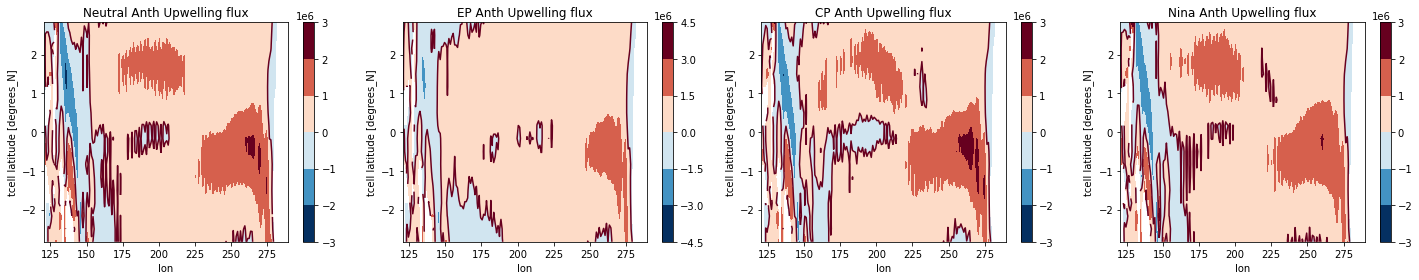

In [45]:
# Anth DIC 300M Upwelling

upwelling_dat=anth_dic_tx_w.sel(st_ocean=300,method='nearest')*rg_m
#upwelling_dat=upwelling_dat*grid.m2
#lon
plt.figure(figsize=(20,4))
#plt.subplot(251)
contour=[0]
lslice=slice(-3,3)
levs=None#np.arange(-0.01,0.01,0.001)
plt.subplot(141)
upwelling_dat.sel(time=neutral_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=neutral_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(upwelling_dat.sel(time=neutral_events,lat=lslice).mean(dim='time'))
#print(asum)
plt.title(f'Neutral Anth Upwelling flux')
#plt.xlim([150,270])
#plt.ylim([-300,0])
#plt.ylim([-3,3])

plt.subplot(142)
upwelling_dat.sel(time=ep_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=ep_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(upwelling_dat.sel(time=ep_events,lat=lslice).mean(dim='time'))
#print(asum)
plt.title(f'EP Anth Upwelling flux')

#plt.ylim([-3,3])
#plt.xlim([150,270])
#plt.ylim([-300,0])


plt.subplot(143)
upwelling_dat.sel(time=cp_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=cp_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(upwelling_dat.sel(time=cp_events,lat=lslice).mean(dim='time'))
plt.title(f'CP Anth Upwelling flux')
#plt.ylim([-3,3])
#plt.xlim([150,270])
#plt.ylim([-300,0])

plt.subplot(144)
upwelling_dat.sel(time=nina_events,lat=lslice).mean(dim='time').plot.contourf(levels=levs)
upwelling_dat.sel(time=nina_events,lat=lslice).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(upwelling_dat.sel(time=nina_events,lat=lslice).mean(dim='time'))
plt.title(f'Nina Anth Upwelling flux')
#plt.ylim([-3,3])
#plt.xlim([150,270])
#plt.ylim([-300,0])
plt.tight_layout()
plt.show()

In [70]:
plt.subplot(243)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])


plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

[ 1.3599635 -0.4736384]
[ 1.3935468 -0.451868 ]
[ 1.2865838  -0.43668118]
[ 1.4432306  -0.44958884]
[ 0.5466657 -0.8227218]
[ 0.62119514 -0.97216576]
[ 0.55770254 -0.8669416 ]
[ 0.5070494  -0.79465723]


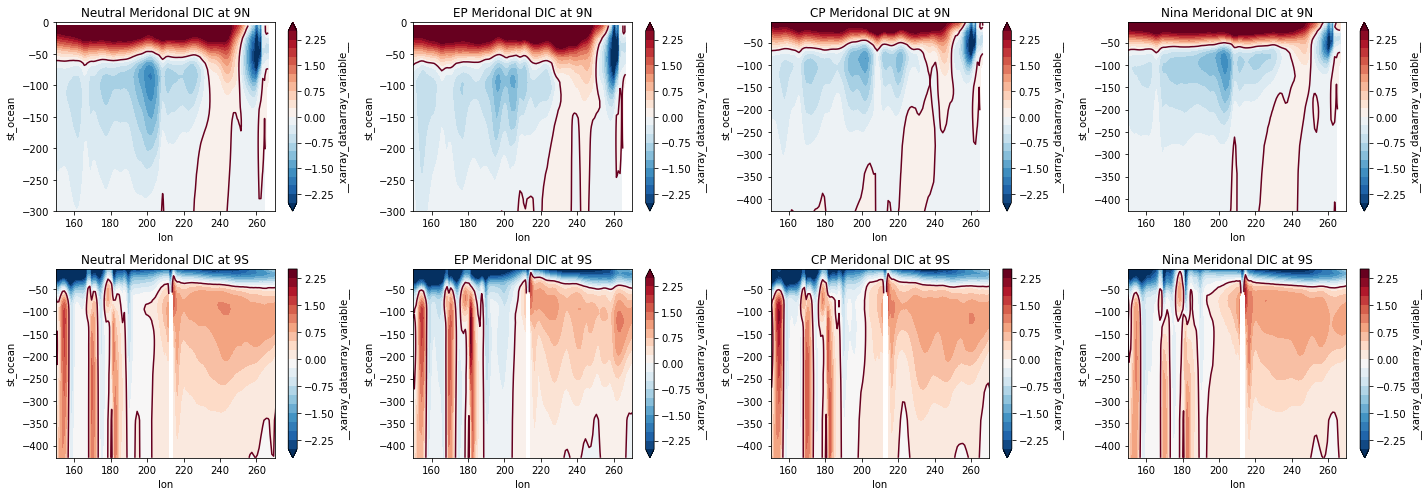

In [70]:
#anth DIC
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-2.5,2.75,0.25)
contour=[0]#60,-60]
lat=15
plt.subplot(241)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 9N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 9N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 9N')
plt.xlim([150,270])


plt.subplot(244)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 9N')
plt.xlim([150,270])


lat=-15
plt.subplot(245)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 9S')
plt.xlim([150,270])

plt.subplot(246)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 9S')
plt.xlim([150,270])


plt.subplot(247)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 9S')
plt.xlim([150,270])


plt.subplot(248)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 9S')
plt.xlim([150,270])


plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [46]:
dic_tx_u.sel(lat=lat,lon=180,method='nearest').plot()#.sel(time=neutral_events).mean(dim='time').plot()

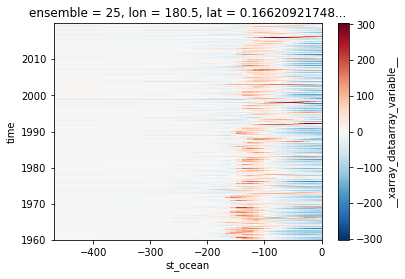

In [47]:
dic_tx_v.sel(lat=lat,lon=180,method='nearest').plot()#.sel(time=neutral_events).mean(dim='time').plot()

[15.803075  -7.8677273]
[ 13.914812 -11.835667]
[ 14.348913 -11.274488]
[15.460638  -7.5663137]


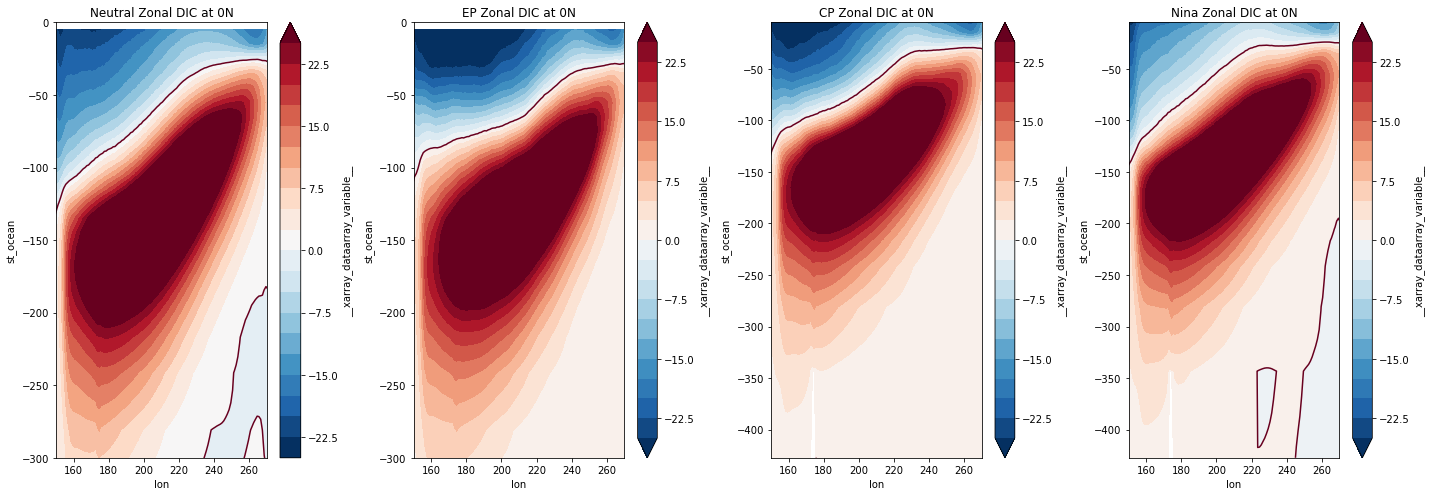

In [27]:
#anth DIC
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-25,27.5,2.5)
contour=[0]#60,-60]
lat=0
plt.subplot(141)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(142)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(143)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Zonal DIC at 0N')
plt.xlim([150,270])


plt.subplot(144)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Zonal DIC at 0N')
plt.xlim([150,270])

plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

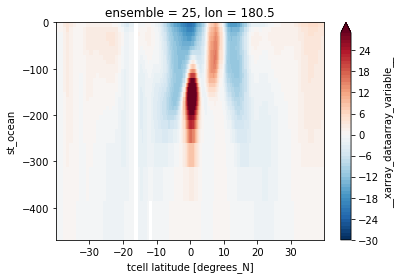

In [33]:
anth_dic_tx_u.sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot(levels=np.arange(-30,30,1))

[ 11.004212 -11.232251]
[  9.368981 -13.844402]
[ 10.727609 -13.979391]
[11.290273 -9.59799 ]


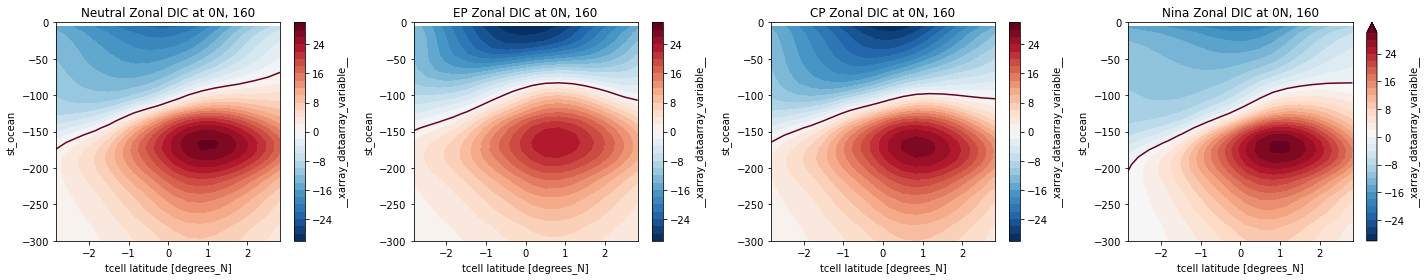

[ 6.013595  -5.9459896]
[ 6.191504 -6.38421 ]
[ 5.036632 -8.907248]
[ 5.756561  -7.0193996]


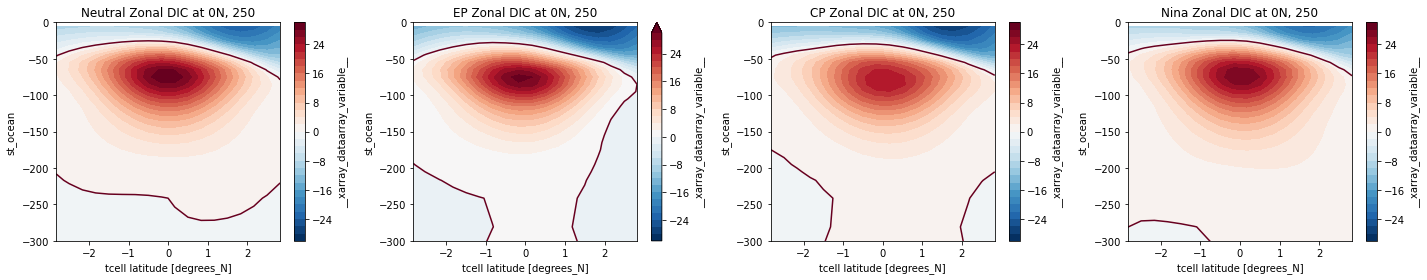

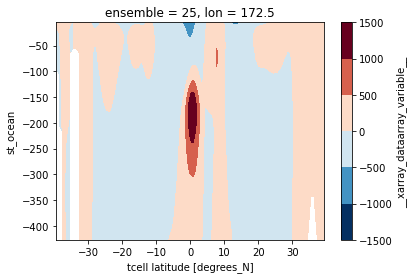

In [18]:
dic_tx_u.sel(lon=172,method='nearest').mean(dim='time').plot.contourf()

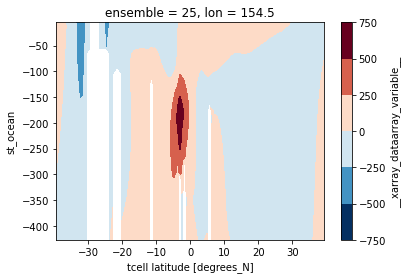

In [10]:
dic_tx_v.sel(lon=154,method='nearest').mean(dim='time').plot.contourf()

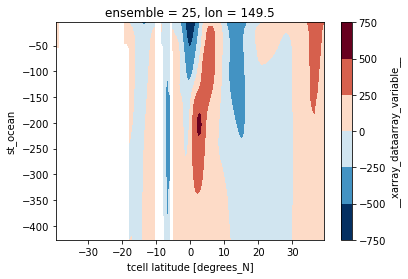

In [15]:
dic_tx_u.sel(lon=149,method='nearest').mean(dim='time').plot.contourf()

In [ ]:
dic_tx_v.mean(dim=['st_ocean','time']).plot()

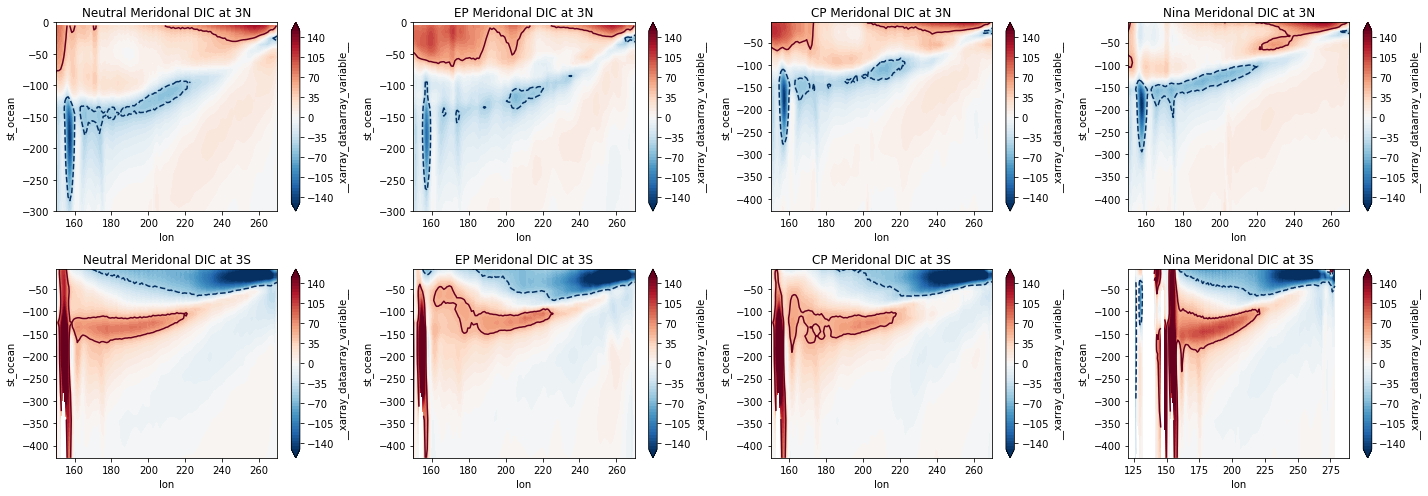

In [34]:
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-150,155,5)
contour=[50,-50]
lat=2
plt.subplot(241)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])


lat=-2
plt.subplot(245)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(246)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(247)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(248)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

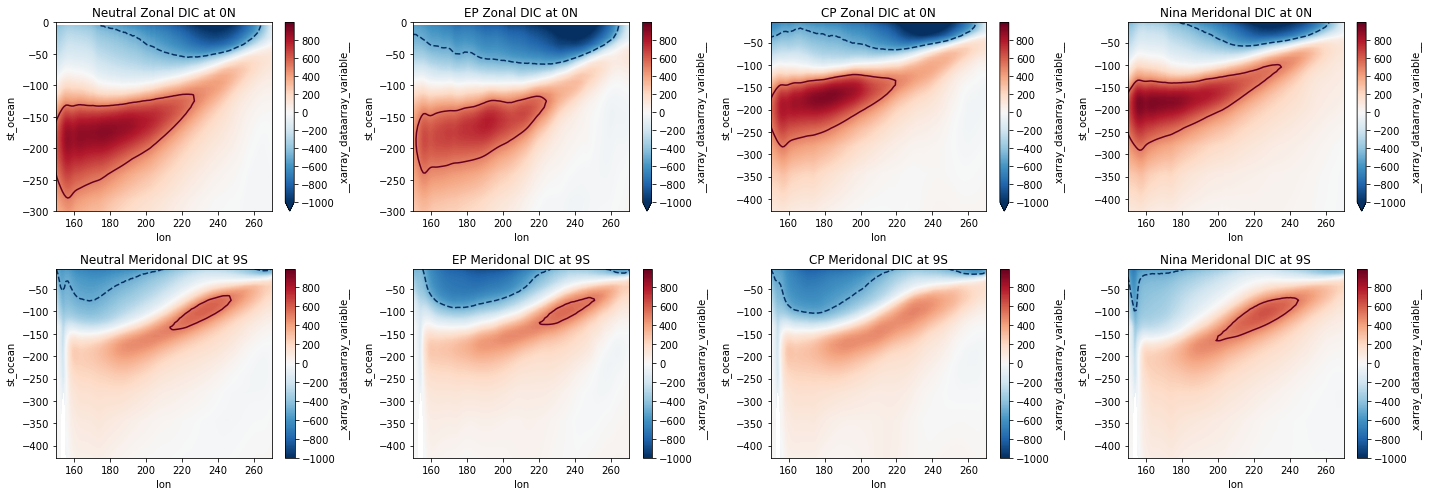

In [32]:
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-1000,1000,5)
contour=[0]#500,-500]
lat=0

plt.subplot(241)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Neutral Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(242)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
plt.title('EP Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(243)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
plt.title('CP Zonal DIC at 0N')
plt.xlim([150,270])


plt.subplot(244)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Nina Meridonal DIC at 0N')
plt.xlim([150,270])


lat=-3
plt.subplot(245)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Neutral Meridonal DIC at 9S')
plt.xlim([150,270])

plt.subplot(246)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
plt.title('EP Meridonal DIC at 9S')
plt.xlim([150,270])


plt.subplot(247)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
plt.title('CP Meridonal DIC at 9S')
plt.xlim([150,270])


plt.subplot(248)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
plt.title('Nina Meridonal DIC at 9S')
plt.xlim([150,270])



plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [ ]:
# Merge
#anth DIC
plt.figure(figsize=(20,7))

levs=np.arange(-2.5,2.75,0.25)
contour=[0]#60,-60]
lat=3
plt.subplot(341)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#print(asum)
plt.title('Neutral Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(342)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
#print(asum)
plt.title('EP Meridonal DIC at 3N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(343)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3N')
plt.xlim([150,270])


plt.subplot(344)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 3N')
plt.xlim([150,270])




levs=np.arange(-40,40,5)
contour=[0]#500,-500]
lat=0

plt.subplot(345)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(346)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(347)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Zonal DIC at 0N')
plt.xlim([150,270])


plt.subplot(348)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 0N')
plt.xlim([150,270])




levs=np.arange(-2.5,2.75,0.25)
contour=[0]#60,-60]
lat=-3
plt.subplot(3,4,9)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Meridonal DIC at 3S')
plt.xlim([150,270])

plt.subplot(3,4,10)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(3,4,11)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Meridonal DIC at 3S')
plt.xlim([150,270])


plt.subplot(3,4,12)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
#asum1=get_area(dic_tx_v.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'),cs)
plt.title('Nina Meridonal DIC at 3S')
plt.xlim([150,270])


plt.tight_layout()
# Mmol DIC/m2/s
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [66]:
#Anth DIC
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-40,40,5)
contour=[0]#500,-500]
lat=0

plt.subplot(141)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
plt.title('Neutral Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])

plt.subplot(142)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time'))
plt.title('EP Zonal DIC at 0N')
plt.xlim([150,270])
plt.ylim([-300,0])


plt.subplot(143)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time'))
plt.title('CP Zonal DIC at 0N')
plt.xlim([150,270])


plt.subplot(144)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=contour)
asum=xarray_posneg_calc(anth_dic_tx_u.sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time'))
plt.title('Nina Meridonal DIC at 0N')
plt.xlim([150,270])




plt.tight_layout()

# Mmol DIC/m2/s

In [66]:
#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [74]:
eqpac

<xarray.Dataset>
Dimensions:          (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [85]:
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 731, ensemble: 96, st_ocean: 50, lat: 140, lon: 170, sw_ocean: 50, lon_x: 171, lat_x: 141)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-11-01
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 120.0 121.0 122.0 ... 289.0 290.0
  * lat                     (lat) float64 -39.41 -38.44 -37.46 ... 38.38 39.34
  * lat_x                   (lat_x) float64 -39.9 -38.92 -37.95 ... 38.86 39.81
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 140, 171), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [37]:
plt.figure(figsize=(20,7))
plt.subplot(251)
levs=np.arange(-150,155,5)

dic_tx_v.sel(lat=-9,method='nearest').plot.contourf(levels=levs)
plt.title('Meridonal DIC at 9S')
plt.xlim([150,270])

plt.subplot(252)
dic_tx_v.sel(lat=-7,method='nearest').plot.contourf(levels=levs)
plt.title('Meridonal DIC at 7S')
plt.xlim([150,270])

plt.subplot(253)
dic_tx_v.sel(lat=-5,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 5S')

plt.subplot(254)
dic_tx_v.sel(lat=-3,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 3S')

plt.subplot(255)
dic_tx_v.sel(lat=-1,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 1S')

plt.subplot(256)
dic_tx_v.sel(lat=9,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 9N')

plt.subplot(257)
dic_tx_v.sel(lat=7,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 7N')

plt.subplot(258)
dic_tx_v.sel(lat=5,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 5N')

plt.subplot(259)
dic_tx_v.sel(lat=3,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
plt.title('Meridonal DIC at 3N')

plt.subplot(2,5,10)
dic_tx_v.sel(lat=1,method='nearest').plot.contourf(levels=levs)
plt.xlim([150,270])
#.title('Meridonal DIC at 1N')

plt.tight_layout()

# Mmol DIC/m2/s


#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [149]:
u_test=cafe_u.rename({'lon_x':'lon','lat_x':'lat'}).sel(lat=0,method='nearest')

In [150]:
dic_test=adic_cafe.sel(lat=0,method='nearest')

In [158]:
u_test=u_test.sel(lon=u_test.lon[:-1])
u_test['lon']=dic_test.lon

In [164]:
a=u_test.mean(dim='time') # u velocity m/s mean
b=u_test.std(dim='time')*3 # u velocity m/s std
c=dic_test.mean(dim='time') # dic 
d=dic_test.std(dim='time')*3




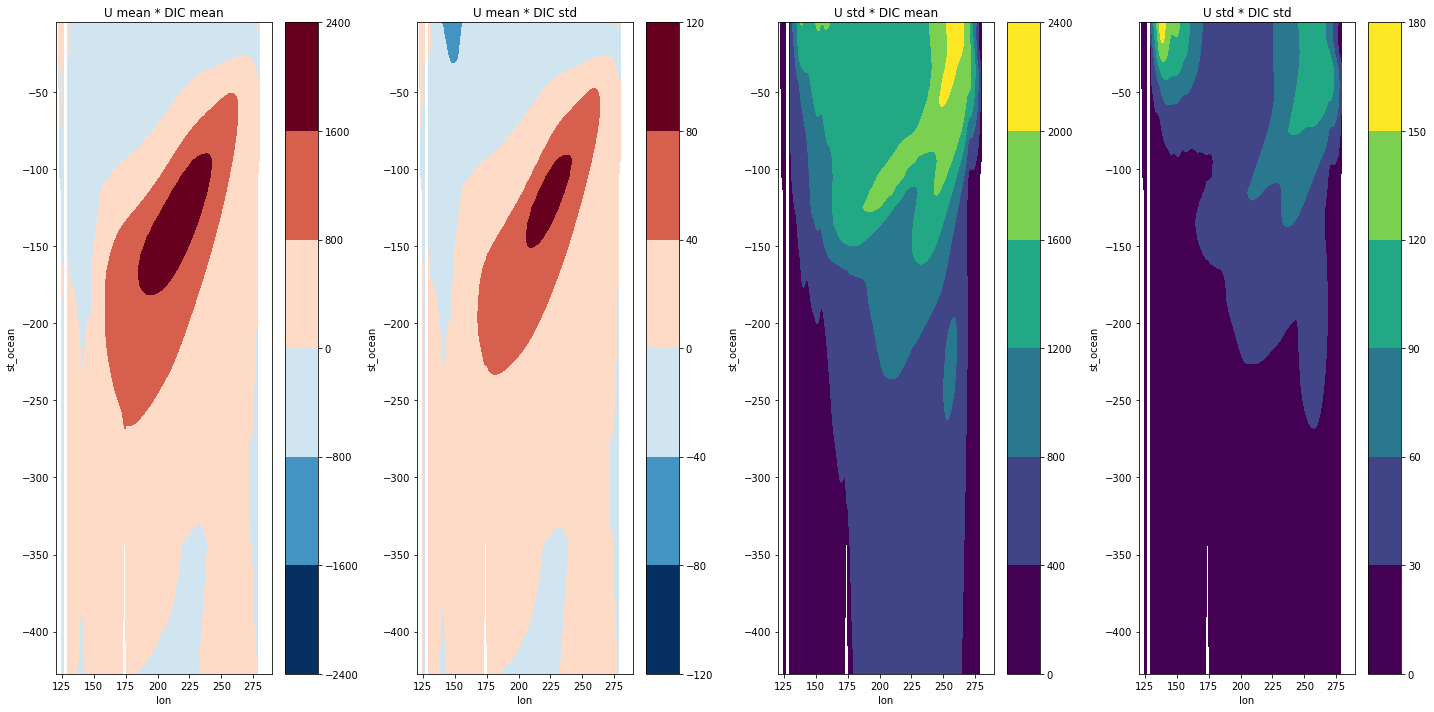

In [166]:
plt.figure(figsize=(20,10))
plt.subplot(141)
(a*c).plot.contourf()
plt.title('U mean * DIC mean')

plt.subplot(142)
(a*d).plot.contourf()
plt.title('U mean * DIC std')

plt.subplot(143)
(b*c).plot.contourf()
plt.title('U std * DIC mean')

plt.subplot(144)
(b*d).plot.contourf()
plt.title('U std * DIC std')

plt.tight_layout()

In [157]:
c.lon.values

array([120.5, 121.5, 122.5, 123.5, 124.5, 125.5, 126.5, 127.5, 128.5,
       129.5, 130.5, 131.5, 132.5, 133.5, 134.5, 135.5, 136.5, 137.5,
       138.5, 139.5, 140.5, 141.5, 142.5, 143.5, 144.5, 145.5, 146.5,
       147.5, 148.5, 149.5, 150.5, 151.5, 152.5, 153.5, 154.5, 155.5,
       156.5, 157.5, 158.5, 159.5, 160.5, 161.5, 162.5, 163.5, 164.5,
       165.5, 166.5, 167.5, 168.5, 169.5, 170.5, 171.5, 172.5, 173.5,
       174.5, 175.5, 176.5, 177.5, 178.5, 179.5, 180.5, 181.5, 182.5,
       183.5, 184.5, 185.5, 186.5, 187.5, 188.5, 189.5, 190.5, 191.5,
       192.5, 193.5, 194.5, 195.5, 196.5, 197.5, 198.5, 199.5, 200.5,
       201.5, 202.5, 203.5, 204.5, 205.5, 206.5, 207.5, 208.5, 209.5,
       210.5, 211.5, 212.5, 213.5, 214.5, 215.5, 216.5, 217.5, 218.5,
       219.5, 220.5, 221.5, 222.5, 223.5, 224.5, 225.5, 226.5, 227.5,
       228.5, 229.5, 230.5, 231.5, 232.5, 233.5, 234.5, 235.5, 236.5,
       237.5, 238.5, 239.5, 240.5, 241.5, 242.5, 243.5, 244.5, 245.5,
       246.5, 247.5,

In [156]:
a.lon.values

array([120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
       164., 165., 166., 167., 168., 169., 170., 171., 172., 173., 174.,
       175., 176., 177., 178., 179., 180., 181., 182., 183., 184., 185.,
       186., 187., 188., 189., 190., 191., 192., 193., 194., 195., 196.,
       197., 198., 199., 200., 201., 202., 203., 204., 205., 206., 207.,
       208., 209., 210., 211., 212., 213., 214., 215., 216., 217., 218.,
       219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229.,
       230., 231., 232., 233., 234., 235., 236., 237., 238., 239., 240.,
       241., 242., 243., 244., 245., 246., 247., 248., 249., 250., 251.,
       252., 253., 254., 255., 256., 257., 258., 259., 260., 261., 262.,
       263., 264., 265., 266., 267., 268., 269., 27

In [37]:
anth_dic_cafe.sel(lat=0,method='nearest').mean(dim=['st_ocean','time'])

<xarray.DataArray '__xarray_dataarray_variable__' (lon: 170)>
array([      nan, 40.56294 , 42.61852 , 39.386593, 40.308666, 41.22447 ,
       41.324986,       nan, 38.053127, 38.254772, 38.44363 , 38.645596,
       38.825413, 38.93643 , 39.0592  , 39.2015  , 39.386017, 39.623135,
       39.841274, 40.03564 , 40.184418, 40.278214, 40.33303 , 40.35338 ,
       40.34908 , 40.334095, 40.35171 , 40.39841 , 40.3767  , 40.291733,
       40.22322 , 40.16093 , 40.100098, 40.036648, 39.96365 , 39.902996,
       39.86131 , 39.815998, 39.75502 , 39.68832 , 39.624516, 39.563423,
       39.505604, 39.44866 , 39.39301 , 39.33976 , 39.28532 , 39.230694,
       39.173325, 39.116066, 39.053223, 38.99667 , 38.93004 , 39.74125 ,
       38.79327 , 38.71795 , 38.64584 , 38.585648, 38.517807, 38.451275,
       38.381195, 38.31173 , 38.241985, 38.16609 , 38.09137 , 38.015324,
       37.934265, 37.852634, 37.765697, 37.680374, 37.593273, 37.505142,
       37.41475 , 37.32263 , 37.230373, 37.137924, 37.039352, 36.944138,
       36.840797, 36.73759 , 36.631565, 36.52223 , 36.41337 , 36.30334 ,
       36.191654, 36.07654 , 35.960033, 35.847   , 35.730083, 35.61317 ,
       35.493114, 35.37173 , 35.251324, 35.124905, 34.99969 , 34.87583 ,
       34.750526, 34.629375, 34.504208, 34.382328, 34.261826, 34.139633,
       34.024334, 33.905575, 33.79059 , 33.673946, 33.557137, 33.447456,
       33.336037, 33.227768, 33.1224  , 33.017353, 32.91509 , 32.808807,
       32.70716 , 32.607327, 32.509197, 32.41658 , 32.32371 , 32.236855,
       32.148026, 32.06006 , 31.976273, 31.891954, 31.815956, 31.739607,
       31.66772 , 31.600384, 31.535952, 31.480175, 31.42568 , 31.375223,
       31.326044, 31.27736 , 31.23338 , 31.194675, 31.165628, 31.140812,
       31.119698, 31.101837, 31.086025, 31.075857, 31.065935, 31.058727,
       31.052784, 31.048103, 31.039778, 31.018509, 30.979338, 30.884592,
       30.786064, 30.689049, 30.554771, 30.399542, 30.229406, 30.025972,
       29.791904, 29.536486, 29.19827 , 31.848387,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan], dtype=float32)
Coordinates:
    ensemble  int32 ...
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
    lat       float64 0.1662

In [ ]:
contour_level=0.4
plt.figure(figsize=(18,4))


plt.subplot(111)
anth_dic_cafe.sel(lat=0,method='nearest').mean(dim=['time']).plot.contourf()#(levels=np.arange(-1,1.11,0.1))
#cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
#cafe80.collections[0].set_label('CP')
#plt.xlim([150,270])
#plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC mean DIC')
plt.show()

No handles with labels found to put in legend.


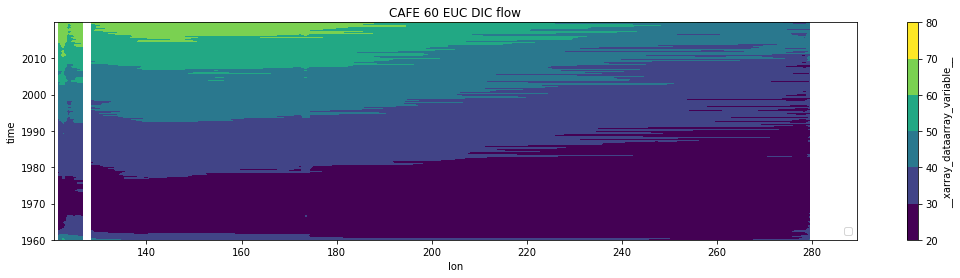

In [39]:
contour_level=0.4
plt.figure(figsize=(18,4))


plt.subplot(111)
anth_dic_cafe.sel(lat=0,method='nearest').mean(dim=['st_ocean']).plot.contourf()#(levels=np.arange(-1,1.11,0.1))
#cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
#cafe80.collections[0].set_label('CP')
#plt.xlim([150,270])
#plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC DIC flow')
plt.show()

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


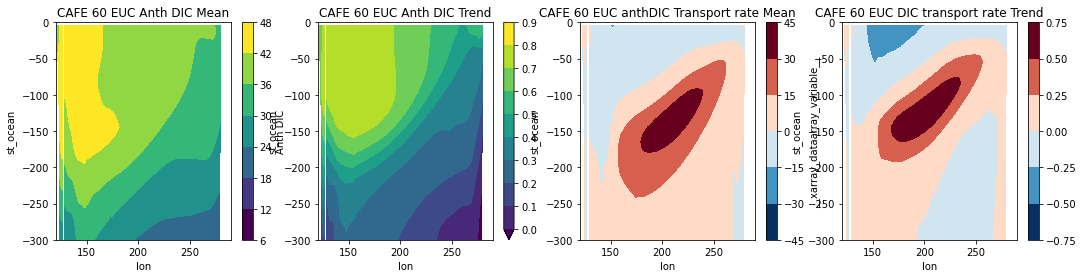

In [63]:
contour_level=0.4
plt.figure(figsize=(18,4))


plt.subplot(141)
anth_dic_cafe.sel(lat=0,method='nearest').mean(dim=['time']).plot.contourf()
plt.title('CAFE 60 EUC Anth DIC Mean')
plt.ylim([-300,0])

plt.subplot(142)
(xarray_get_trend(anth_dic_cafe.sel(lat=0,method='nearest')).sel(parameter=0)*365).plot.contourf(cmap='viridis',levels=np.arange(0,1,0.1))
plt.title('CAFE 60 EUC Anth DIC Trend')
plt.ylim([-300,0])

plt.subplot(143)
anth_dic_tx_u.sel(lat=0,method='nearest').mean(dim=['time']).plot.contourf()#(levels=np.arange(-1,1.11,0.1))
plt.title('CAFE 60 EUC anthDIC Transport rate Mean')
plt.ylim([-300,0])
#cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
#cafe80.collections[0].set_label('CP')
#plt.xlim([150,270])
#plt.ylim([-300,0])
#plt.legend(loc='lower right')



plt.subplot(144)
(xarray_get_trend(anth_dic_tx_u.sel(lat=0,method='nearest')).drop(['lat','ensemble']).sel(parameter=0)*365).plot.contourf()
#cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
#cafe80.collections[0].set_label('CP')
#plt.xlim([150,270])
#plt.ylim([-300,0])
#plt.legend(loc='lower right')
plt.title('CAFE 60 EUC DIC transport rate Trend')
plt.ylim([-300,0])
plt.show()

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


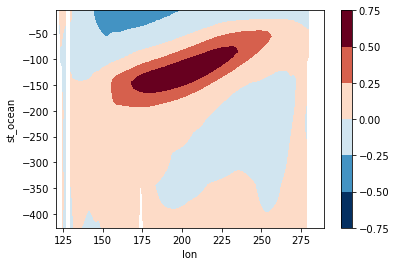

In [58]:
(xarray_get_trend(anth_dic_tx_u.sel(lat=0,method='nearest')).drop(['lat','ensemble']).sel(parameter=0)*365).plot.contourf()

In [ ]:
plt.subplot(142)
cafe_u.sel(lat_x=0,method='nearest').sel(time=ep_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('EP')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC EP')


plt.subplot(143)
cafe_u.sel(lat_x=0,method='nearest').sel(time=nina_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('Nina')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Nina')

plt.subplot(144)
cafe_u.sel(lat_x=0,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contourf(levels=np.arange(-1,1.11,0.1))
cafe80=cafe_u.sel(lat_x=0,method='nearest').sel(time=slice('1980','1990')).mean(dim='time').plot.contour(levels=[contour_level],colors='r')
cafe80.collections[0].set_label('Neutral')
plt.xlim([150,270])
plt.ylim([-300,0])
plt.legend(loc='lower right')
plt.title('CAFE 60 EUC Neutral')

In [ ]:
adic_cafe.mean(dim='time')

In [ ]:
cafe_v1['st_ocean']=dic.st_ocean
cafe_v1['lat']=dic.lat
cafe_v1['lon']=dic.lon
cafe_v1['time']=dic.time

In [ ]:
# Keeps crashing Kernal??
#dic_tx=cafe_v1*dic['adic']

In [ ]:
#dic_tx=cafe_v1*dic['adic']

In [ ]:
cafe_v_interp=cafe_v1.interp_like(dic['adic'])

In [ ]:
dic_tx=dic['adic']*cafe_v

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(251)
cafe_v.sel(lat_x=-9,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(252)
cafe_v.sel(lat_x=-7,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])
plt.subplot(253)
cafe_v.sel(lat_x=-5,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(254)
cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(255)
cafe_v.sel(lat_x=-1,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(256)
cafe_v.sel(lat_x=9,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(257)
cafe_v.sel(lat_x=7,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(258)
cafe_v.sel(lat_x=5,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(259)
cafe_v.sel(lat_x=3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.subplot(2,5,10)
cafe_v.sel(lat_x=1,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
plt.xlim([150,270])

plt.tight_layout()




#cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))

In [ ]:
#d[0,:]

In [14]:
deps=cafe_u.sel(lat_x=0,method='nearest').sel(st_ocean=slice(0,-300)).dropna(dim='lon_x').idxmax(dim='st_ocean',skipna=True)#.plot()

In [65]:
depth=deps.sel(lon_x=lon)#

In [ ]:
cafe_u.sel(lat_x=0,method='nearest').sel(st_ocean=slice(0,-300)).dropna(dim='lon_x').idxmax(dim='st_ocean',skipna=True).plot()

In [ ]:
# EUC cross section and 
plt.figure(figsize=(16,5))
plt.subplot(121)
deps.mean(dim='time').plot()
plt.xlim([150,270])
plt.title('Max EUC U speed depth')

plt.subplot(122)
(xarray_get_trend(deps).sel(parameter=0)*365).plot()
plt.xlim([150,270])
plt.title('Max EUC U speed Depth Trend / Yr')

In [ ]:
cafe_u.sel(lat_x=0,method='nearest').sel(st_ocean=slice(0,-300)).dropna(dim='lon_x').mean(dim='time').argmax(dim='st_ocean',skipna=True).plot()

In [ ]:

cafe_u.sel(lat_x=0,lon_x=180,st_ocean=-170,method='nearest').plot()#.sel(st_ocean=slice(0,-300))

In [ ]:
dic_cafe.sel(lat=0,lon=lon,st_ocean=depth,method='nearest')

In [64]:
deps

<xarray.DataArray 'st_ocean' (time: 720, lon_x: 153)>
array([[ -15.,  -15.,  -15., ...,  -85.,  -85.,   -5.],
       [ -15.,  -15.,  -15., ...,   -5.,   -5.,   -5.],
       [  -5.,   -5.,  -15., ...,  -75.,  -65.,  -55.],
       ...,
       [ -15.,  -15.,   -5., ..., -155., -145.,  -85.],
       [  -5.,   -5.,   -5., ..., -175., -165.,   -5.],
       [  -5.,   -5.,   -5., ..., -145., -145., -145.]])
Coordinates:
    ensemble  int32 25
    lat_x     float64 -1e-09
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon_x     (lon_x) float64 124.0 125.0 126.0 129.0 ... 276.0 277.0 278.0

In [ ]:
adic_cafe.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest')#.plot()

In [ ]:
anth_dic_cafe.sel(st_ocean=

In [69]:
#depth

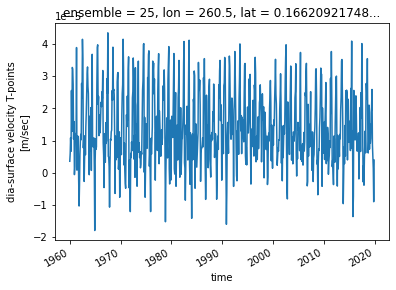

In [68]:
v.sel(lat=0,lon=lon,sw_ocean=depth,method='nearest').plot()#.where('sw_ocean'==depth).sel(time='2010-01-01',method='nearest').values

In [77]:
anth_dic_cafe.name='Anth DIC'

In [79]:
#anth_dic_cafe

<xarray.DataArray 'Anth DIC' (time: 720, st_ocean: 26, lat: 140, lon: 170)>
[445536000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

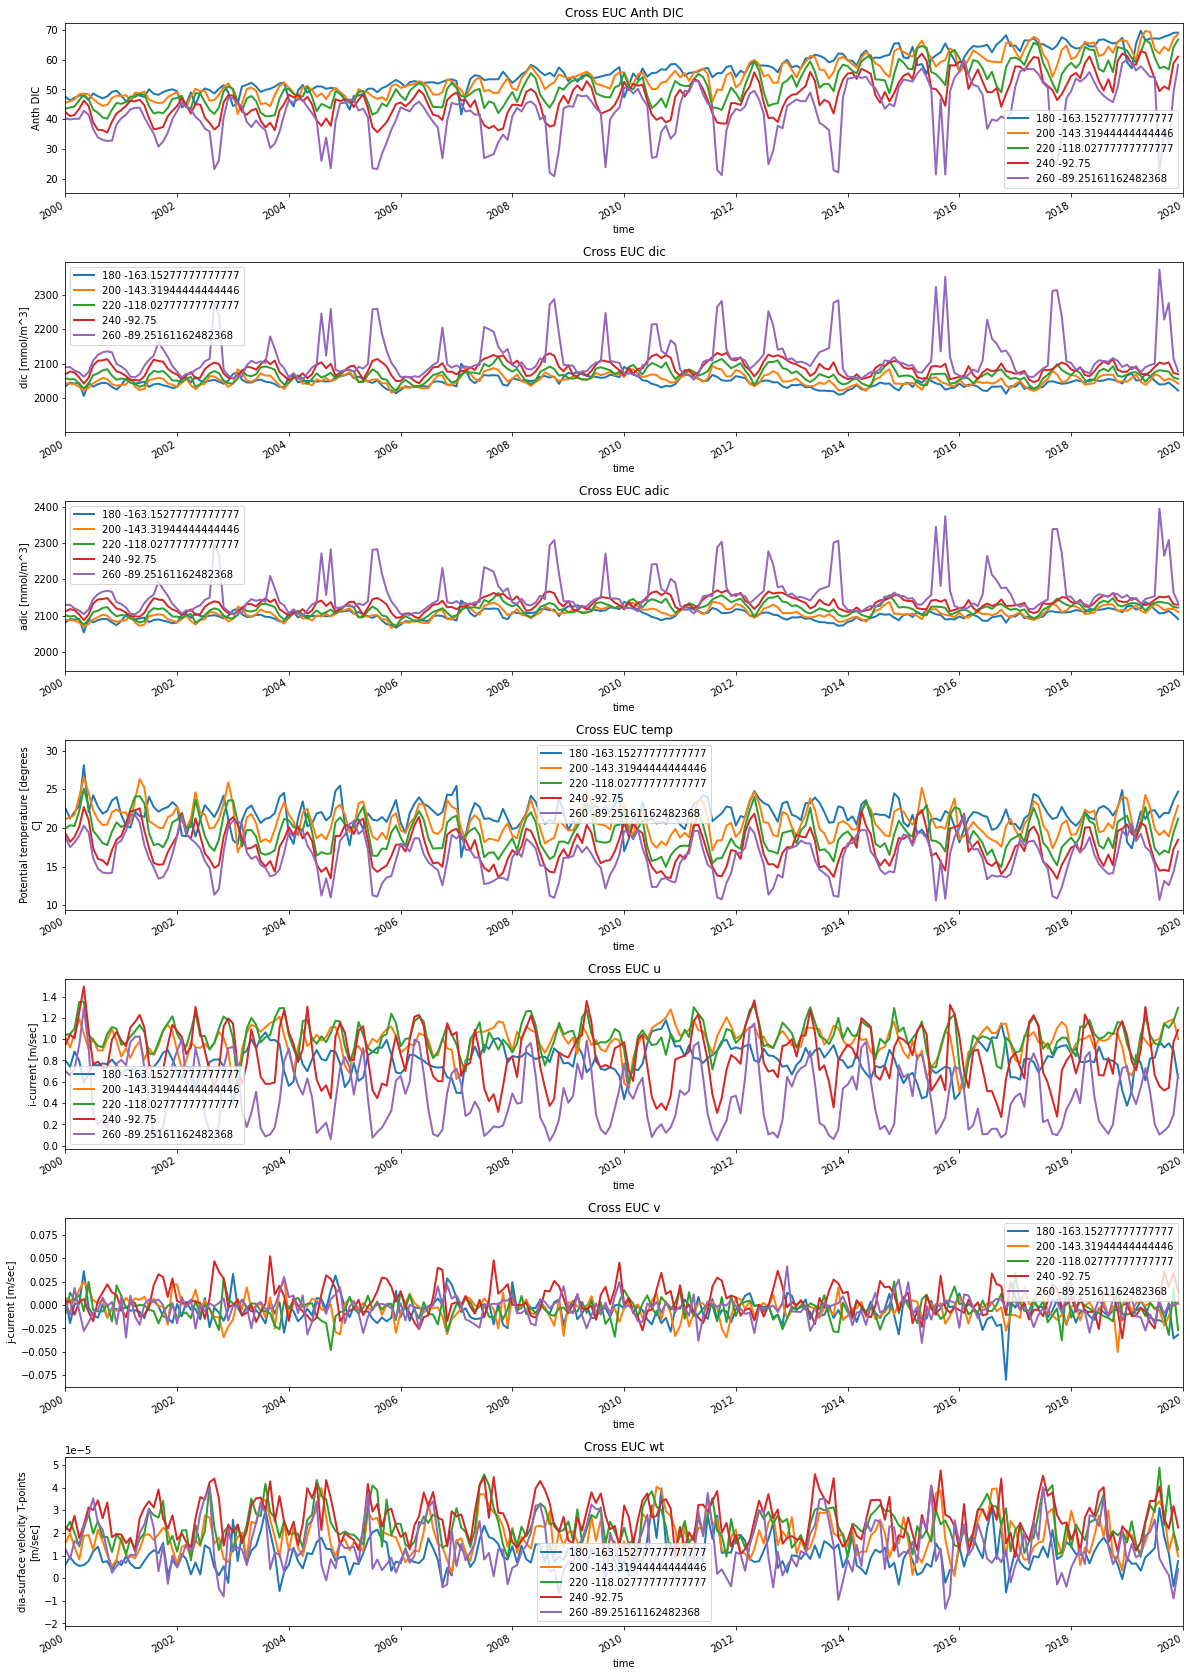

In [82]:
lons=[180,200,220,240,260]
anth_dic_cafe.name='Anth DIC'
varz=[anth_dic_cafe,dic_cafe,adic_cafe,cafe_temp,cafe_u,cafe_v,cafe_wt]
fig = plt.figure(figsize=((8.27*2),11.69*2))
for i,v in enumerate(varz):
    plt.subplot(7,1,i+1)
    for i,lon in enumerate(lons):
        depth=deps.sel(lon_x=lon)#.values
        #plt.subplot(5,1,i+1)
        #dic.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest')['dic'].plot()
        try:
            #xarray_detrend(deseasonaliser(
            v.sel(lat=0,lon=lon,st_ocean=depth,method='nearest').plot(label=f'{lon} {depth.mean().values}',linewidth=2)
        except:
            pass
            try:
                v.sel(lat_x=0,lon_x=lon,st_ocean=depth,method='nearest').plot(label=f'{lon} {depth.mean().values}',linewidth=2)
            except:
                v.sel(lat=0,lon=lon,sw_ocean=depth,method='nearest').plot(label=f'{lon} {depth.mean().values}',linewidth=2)
        #plt.show()
        plt.xlim(['2000-01-01','2020-01-01'])
    plt.title(f'Cross EUC {str(v.name)}')
    plt.legend()
plt.tight_layout()
plt.show()

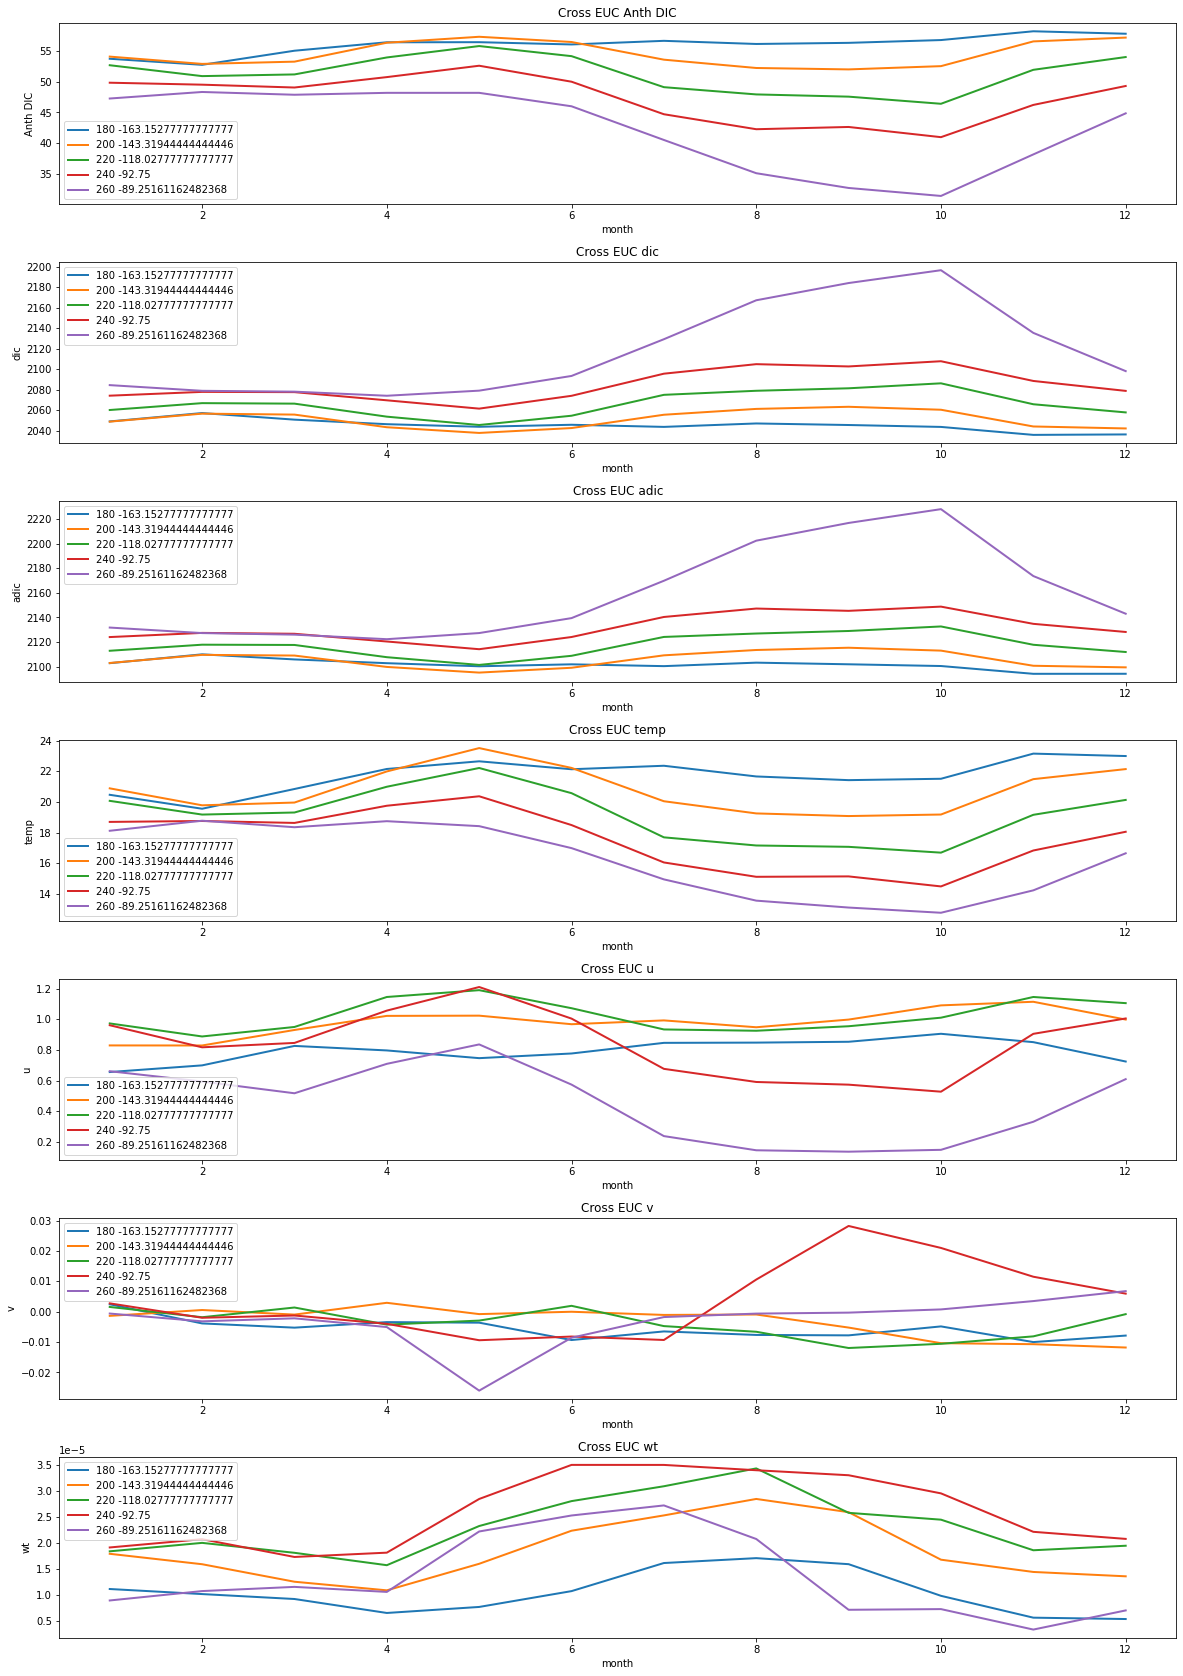

In [16]:
#Seasonality
lons=[180,200,220,240,260]
anth_dic_cafe.name='Anth DIC'
varz=[anth_dic_cafe,dic_cafe,adic_cafe,cafe_temp,cafe_u,cafe_v,cafe_wt]
fig = plt.figure(figsize=((8.27*2),11.69*2))
for i,v in enumerate(varz):
    plt.subplot(7,1,i+1)
    for i,lon in enumerate(lons):
        depth=deps.sel(lon_x=lon)#.values
        #plt.subplot(5,1,i+1)
        #dic.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest')['dic'].plot()
        try:
            #xarray_detrend(deseasonaliser(
            v.sel(lat=0,lon=lon,st_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).groupby('time.month').mean().plot(label=f'{lon} {depth.mean().values}',linewidth=2)
        except:
            pass
            try:
                v.sel(lat_x=0,lon_x=lon,st_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).groupby('time.month').mean().plot(label=f'{lon} {depth.mean().values}',linewidth=2)
            except:
                v.sel(lat=0,lon=lon,sw_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01')).groupby('time.month').mean().plot(label=f'{lon} {depth.mean().values}',linewidth=2)
        #plt.show()
        #plt.xlim(['2000-01-01','2020-01-01'])
    plt.title(f'Cross EUC {str(v.name)}')
    plt.legend()
plt.tight_layout()
plt.show()

In [43]:
v.sel(lat=0,lon=lon,st_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01'))

<xarray.DataArray 'Anth DIC' (time: 240)>
array([47.61609 , 46.303833, 47.19336 , ..., 68.29053 , 69.071655, 69.162476],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  (time) float64 -175.0 -175.0 -175.0 ... -155.0 -155.0 -155.0
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
    lon       float64 180.5
    lat       float64 0.1662
    lat_x     float64 -1e-09
    lon_x     float64 180.0

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_tr

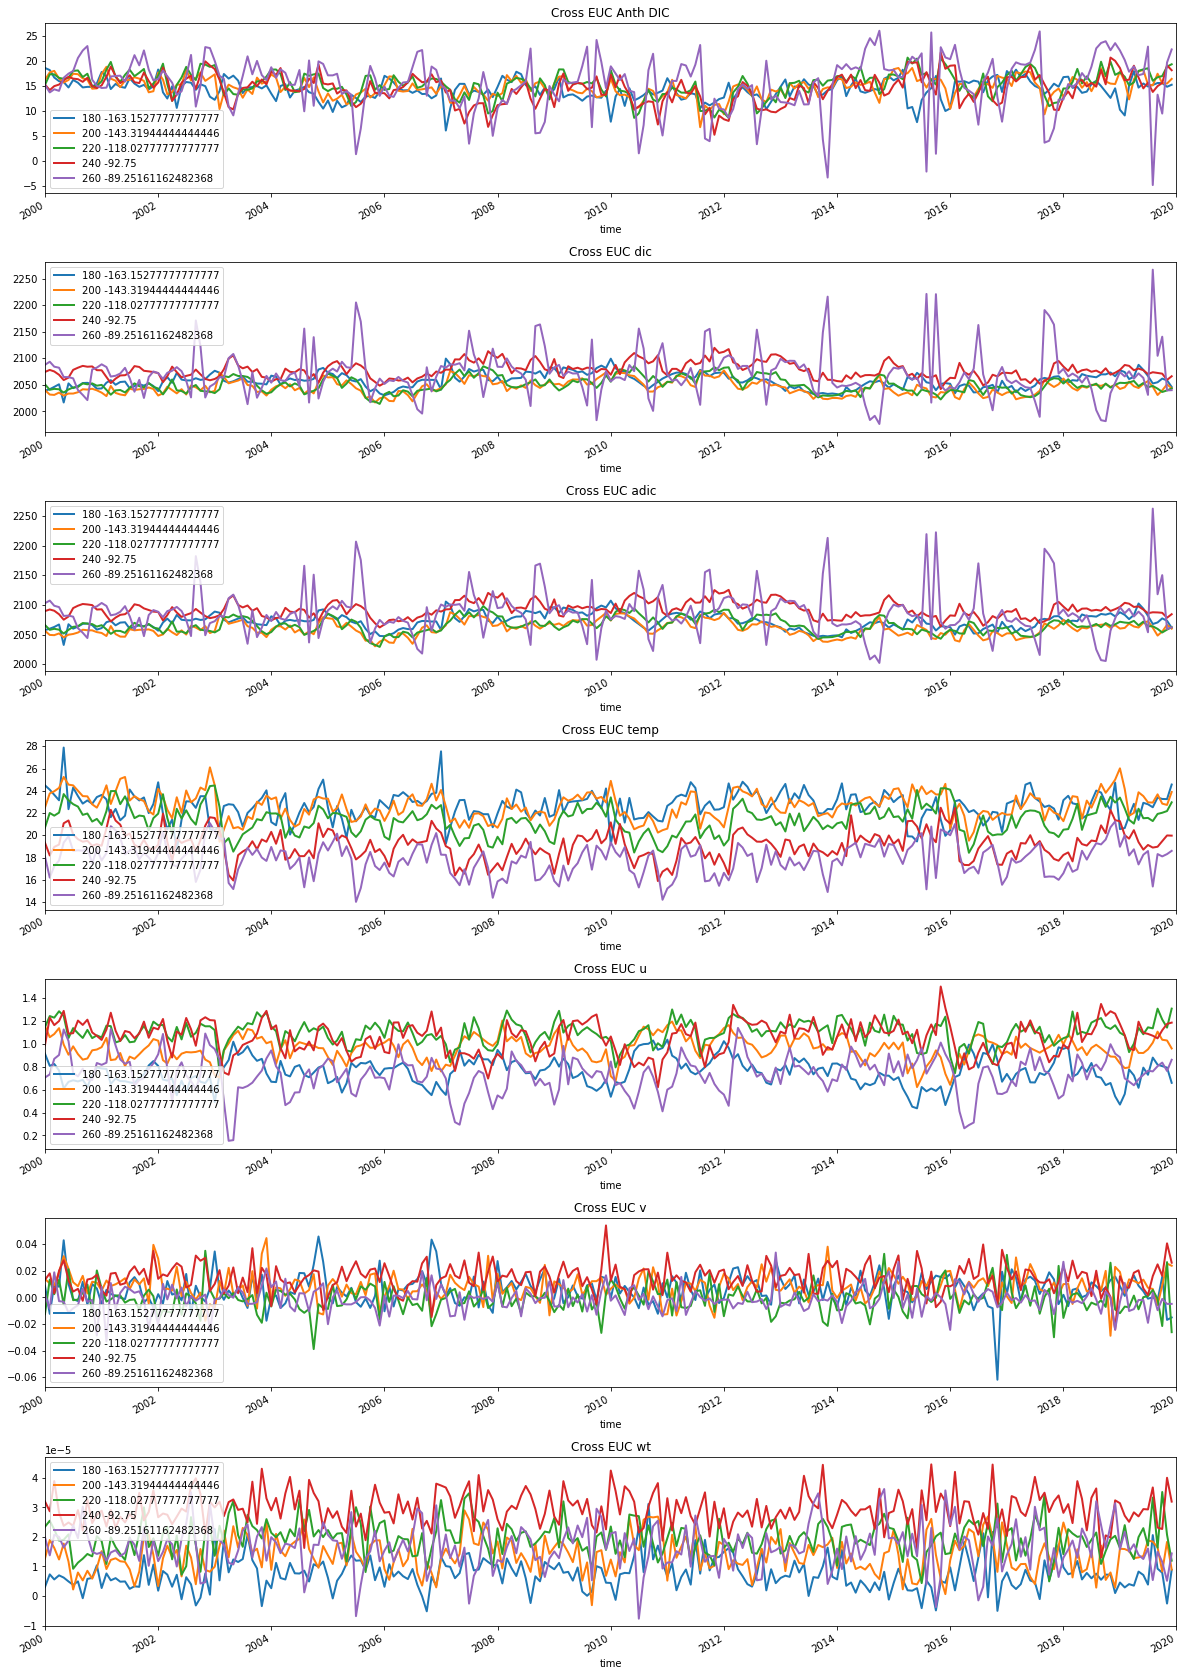

In [46]:
lons=[180,200,220,240,260]
anth_dic_cafe.name='Anth DIC'
varz=[anth_dic_cafe,dic_cafe,adic_cafe,cafe_temp,cafe_u,cafe_v,cafe_wt]
fig = plt.figure(figsize=((8.27*2),11.69*2))
for i,v in enumerate(varz):
    plt.subplot(7,1,i+1)
    for i,lon in enumerate(lons):
        depth=deps.sel(lon_x=lon)#.values
        #plt.subplot(5,1,i+1)
        #dic.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest')['dic'].plot()
        try:
            #xarray_detrend(deseasonaliser(
            xarray_detrend(deseasonaliser(v.sel(lat=0,lon=lon,st_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01')))).plot(label=f'{lon} {depth.mean().values}',linewidth=2)
        except:
            pass
            try:
                xarray_detrend(deseasonaliser(v.sel(lat_x=0,lon_x=lon,st_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01')))).plot(label=f'{lon} {depth.mean().values}',linewidth=2)
            except:
                xarray_detrend(deseasonaliser(v.sel(lat=0,lon=lon,sw_ocean=depth,method='nearest').sel(time=slice('2000-01-01','2020-01-01')))).plot(label=f'{lon} {depth.mean().values}',linewidth=2)
        #plt.show()
        plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
    plt.title(f'Cross EUC {str(v.name)}')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
lons=[180,200,220,240,260]
varz=[dic,adic,cafe_temp,cafe_u,cafe_v,cafe_wt]

for v in varz:
    plt.figure(figsize=(15,7))
    for i,lon in enumerate(lons):
        depth=deps.sel(lon_x=lon).values
        #plt.subplot(5,1,i+1)
        #dic.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest')['dic'].plot()
        try:
            v.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
        except:
            try:
                v.sel(lat_x=0,lon_x=lon,st_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
            except:
                v.sel(lat=0,lon=lon,sw_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
        #plt.show()
        plt.xlim(['2000-01-01','2020-01-01'])
    plt.title(f'Cross EUC {str(v.name)}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
varz=[

In [ ]:
lons=[180,200,220,240,260]
plt.figure(figsize=(20,12))
for i,lon in enumerate(lons):
    depth=deps.sel(lon_x=lon).values
    #plt.subplot(5,1,i+1)
    #dic.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest')['dic'].plot()
    ((adic_cafe.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest'))).plot(label=f'{lon} {depth.mean()}',linewidth=2)
    #plt.show()
    #plt.xlim(['2000-01-01','2020-01-01'])
plt.legend()
plt.tight_layout()

In [ ]:
cafe_temp

In [ ]:
lons=[180,200,220,240,260]
plt.figure(figsize=(26,8))
for i,lon in enumerate(lons):
    depth=deps.sel(lon_x=lon).values
    #plt.subplot(5,1,i+1)
    cafe_temp.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
    #cafe_temp.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest').plot()
    #plt.show()
    plt.xlim(['2000-01-01','2020-01-01'])
plt.legend()
plt.tight_layout()

In [ ]:
cafe_wt

In [ ]:
lons=[180,200,220,240,260]
plt.figure(figsize=(26,8))
for i,lon in enumerate(lons):
    depth=deps.sel(lon_x=lon).values
    #plt.subplot(5,1,i+1)
    cafe_u.sel(lat_x=0,lon_x=lon,st_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
    #cafe_v.sel(lat_x=0,lon_x=lon,st_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
    cafe_wt.sel(lat=0,lon=lon,sw_ocean=depth.mean(),method='nearest').plot(label=f'{lon} {depth.mean()}',linewidth=2)
    
    #cafe_temp.sel(lat=0,lon=lon,st_ocean=depth.mean(),method='nearest').plot()
    #plt.show()
    #plt.xlim(['2000-01-01','2020-01-01'])
plt.legend()
plt.tight_layout()

In [ ]:
deps#.sel(lon_x=180,method='nearest').values

In [ ]:
deps.plot()

In [ ]:
# SINGLE YEAR VERSION Figure 1

sday='2000-01-01'
eday='2020-01-01'
# A3 is (11.69,16.53)
fig = plt.figure(figsize=(8.27*4,11.69*4)) #Inches Portrait
plot_pacific_subplot(cafe_sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=521,title='Mean SST Cafe',levels=np.arange(18,32,1))
plot_pacific_subplot(xarray_get_trend(cafe_sst.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=522,title='Mean SST Cafe',levels=np.arange(-0.1,0.1,0.005))

plot_pacific_subplot(rey_sst.sst.sel(time=slice(sday,eday)).mean(dim='time'),sb=523,title='Mean SST Reynolds',levels=np.arange(18,32,1))
plot_pacific_subplot(xarray_get_trend(rey_sst.sst.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=524,title='Mean SST Reynolds',levels=np.arange(-0.1,0.1,0.005))

plot_pacific_subplot(cafe_u.chunk({'st_ocean':-1}).mean('st_ocean').rename({'lon_x':'lon','lat_x':'lat'}).sel(time=slice(sday,eday)).mean(dim='time'),sb=525,title='U Cafe')
plot_pacific_subplot(xarray_get_trend(cafe_u.chunk({'st_ocean':-1}).mean('st_ocean').rename({'lon_x':'lon','lat_x':'lat'}).sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=526,title='U Cafe')

plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=527,title='V Cafe')
plot_pacific_subplot(xarray_get_trend(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=528,title='V Cafe')


plot_pacific_subplot(upwelling_cafe.sel(time=slice(sday,eday)).mean(dim='time'),sb=529,title='Upwelling Cafe')
plot_pacific_subplot(xarray_get_trend(upwelling_cafe.sel(time=slice(sday,eday))).sel(parameter=0),sb=[5,2,10],title='Upwelling Cafe')
plt.tight_layout()


# SINGLE YEAR VERSION Figure 2


sday='2000-01-01'
eday='2020-01-01'
fig = plt.figure(figsize=(40,20))
plot_pacific_subplot((land_co2*1000).sel(time=slice(sday,eday)).mean(dim='time'),sb=521,title='Land CO2')#,levels=np.arange(18,32,1))
plot_pacific_subplot(xarray_get_trend((land_co2*1000).sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=522,title='Land CO2 Trend',)

plot_pacific_subplot(cafe_co2.sel(time=slice(sday,eday)).mean(dim='time'),sb=523,title='CAFE CO2')#,levels=np.arange(18,32,1))
plot_pacific_subplot(xarray_get_trend(cafe_co2.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=524,title='CAFE CO2 Trend')

plot_pacific_subplot(cafe_co2_natural.sel(time=slice(sday,eday)).mean(dim='time'),sb=525,title='Natural CO2')
plot_pacific_subplot(xarray_get_trend(cafe_co2_natural.sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=526,title='Natural CO2')

plot_pacific_subplot(dic_cafe.sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=529,title='DIC',levels=np.arange(1800,2200,20))
plot_pacific_subplot(xarray_get_trend(dic_cafe.sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=[5,2,10],title='DIC',levels=np.arange(-0.025,0.025,0.0025))

plot_pacific_subplot(adic_cafe.sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=527,title='aDIC',levels=np.arange(1800,2200,20))
plot_pacific_subplot(xarray_get_trend(adic_cafe.sel(st_ocean=slice(0,-100)).mean(dim='st_ocean').sel(time=slice(sday,eday))).sel(parameter=0)*365,sb=528,title='aDIC',levels=np.arange(-0.025,0.025,0.0025))

plt.tight_layout()
#plot_pacific_subplot(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday)).mean(dim='time'),sb=527,title='V Cafe')
#plot_pacific_subplot(xarray_get_trend(cafe_v.chunk({'st_ocean':-1}).rename({'lon_x':'lon','lat_x':'lat'}).mean('st_ocean').sel(time=slice(sday,eday))).sel(parameter=0),sb=528,title='V Cafe')


#plot_pacific_subplot(upwelling.sel(time=slice(sday,eday)).mean(dim='time'),sb=529,title='Upwelling Cafe')
#plot_pacific_subplot(xarray_get_trend(upwelling.sel(time=slice(sday,eday))).sel(parameter=0),sb=[5,2,10],title='Upwelling Cafe')


In [ ]:
# DOesnt work with line for some reason. 

from matplotlib import animation
from IPython.display import HTML
deps=cafe_u.sel(lat_x=0,method='nearest').sel(st_ocean=slice(0,-300)).dropna(dim='lon_x').idxmax(dim='st_ocean',skipna=True)#.plot()
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
d=deps#u.sel(lat=0,method='nearest')#.mean(dim='time').plot.contourf(cmap='bwr')
cax = d[0,:].plot()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(d[frame,:].values)
    ax.set_title("Time = " + str(d.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(d.time),       # Could also be iterable or list
    interval=200)     # ms between frames
HTML(ani.to_jshtml())

## Figure 1: Means

In [ ]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(sst_cafe.sel(ensemble=25).mean(dim='time'),sb=421,title='Mean SST Cafe',levels=np.arange(18,32,1))
plot_pacific_subplot(sst_rey.mean(dim='time'),sb=422,title='Mean SST Reynolds',levels=np.arange(18,32,1))

plot_pacific_subplot(co2_cafe.sel(ensemble=25).mean(dim='time'),sb=423,title='Mean CO2 Cafe',levels=np.arange(-12,12,1),extend='min')
plot_pacific_subplot(co2_land.mean(dim='time'),sb=424,title='Mean CO2 Landschutzer',levels=np.arange(-12,12,1))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(npp_cafe_25.mean(dim='time'),sb=425,title='Mean NPP Cafe 25',levels=np.arange(0,30,1),cmap='viridis')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(np_dat.mean(dim='time'),sb=426,title='Mean NPP Obs',levels=np.arange(0,30,1),cmap='viridis')
plot_pacific_subplot(npp_cafe_25_sed.mean(dim='time'),sb=427,title='Mean NPP Cafe Sediment Export',levels=np.arange(0,30,1),cmap='viridis',extend='max')

plt.tight_layout()
plt.show()

## Figure 2: Trends

In [ ]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(xarray_get_trend(sst_cafe.sel(ensemble=25)).sel(parameter=0)*365,sb=321,title='Trend SST CAFE',levels=np.arange(-0.09,0.09,0.03),extend='max')
plot_pacific_subplot(xarray_get_trend(sst_rey).sel(parameter=0)*365,sb=322,title='Trend SST Reynolds',levels=np.arange(-0.09,0.09,0.03),extend='max')#,levels=np.arange(18,32,1))

plot_pacific_subplot(xarray_get_trend(co2_cafe.sel(ensemble=25)).sel(parameter=0)*365,sb=323,title='Trend CO2 Cafe',levels=np.arange(-0.2,0.2,0.02),extend='both')
plot_pacific_subplot(xarray_get_trend(co2_land).sel(parameter=0)*365,sb=324,title='Trend CO2 Landschutzer',levels=np.arange(-0.2,0.2,0.02),extend='both')
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(xarray_get_trend(npp_cafe_25).sel(parameter=0)*365,sb=325,title='Trend NPP Cafe 25')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(xarray_get_trend(np_dat).sel(parameter=0)*365,sb=326,title='Trend NPP Obs')
plt.tight_layout()
plt.show()

# Figure 3: Seasonal Magnitude

In [ ]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(sst_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'),sb=321,title='Seasonal Amplitude SST Cafe',cmap='viridis',levels=np.arange(0,4,0.5))
plot_pacific_subplot(sst_rey.groupby('time.month').mean().std(dim='month'),sb=322,title='Seasonal Amplitude SST Reynolds',cmap='viridis',levels=np.arange(0,4,0.5))

plot_pacific_subplot(co2_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'),sb=323,title='Seasonal Amplitude CO2 Cafe',cmap='viridis',levels=np.arange(0,12,1))#,levels=np.arange(-12,12,1))
plot_pacific_subplot(co2_land.groupby('time.month').mean().std(dim='month'),sb=324,title='Seasonal Amplitude CO2 Landschutzer',cmap='viridis',levels=np.arange(0,12,1))#,levels=np.arange(-12,12,1))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(npp_cafe_25.groupby('time.month').mean().std(dim='month'),sb=325,title='Seasonal Amplitude NPP Cafe 25')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(np_dat.groupby('time.month').mean().std(dim='month'),sb=326,title='Seasonal Amplitude NPP Obs')
plt.tight_layout()
plt.show()

<xarray.Dataset>
Dimensions:   (st_ocean: 26, time: 731, lon: 170, lat: 140)
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Data variables:
    salt      (time, st_ocean, lat, lon) float32 ...

# Figure 3b: Seasonal Magnitude / Peak Month

In [ ]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(sst_cafe.sel(ensemble=25).groupby('time.month').mean().idxmax(dim='month'),sb=321,title='Peak Month  SST Cafe',cmap='viridis',levels=np.arange(1,13,1))
plot_pacific_subplot(sst_rey.groupby('time.month').mean().idxmax(dim='month'),sb=322,title='Peak Month SST Reynolds',cmap='viridis',levels=np.arange(1,13,1))

plot_pacific_subplot(co2_cafe.sel(ensemble=25).groupby('time.month').mean().idxmax(dim='month'),sb=323,title='Peak Month  CO2 Cafe',cmap='viridis',levels=np.arange(1,13,1))#,levels=np.arange(-12,12,1))
plot_pacific_subplot(co2_land.groupby('time.month').mean().idxmax(dim='month'),sb=324,title='Peak Amplitude CO2 Landschutzer',cmap='viridis',levels=np.arange(1,13,1))#,levels=np.arange(-12,12,1))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(npp_cafe_25.groupby('time.month').mean().idxmax(dim='month'),sb=325,title='Peak Month NPP Cafe 25',cmap='viridis',levels=np.arange(1,13,1))
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(np_dat.groupby('time.month').mean().idxmax(dim='month'),sb=326,title='Peak Month NPP Obs',cmap='viridis',levels=np.arange(1,13,1))
plt.tight_layout()
plt.show()

In [ ]:
#plot_pacific(sst_rey.mean(dim='time'))
#plot_pacific(sst_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'))
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim='month'))
#plot_pacific(co2_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'))
#plot_pacific(co2_land.groupby('time.month').mean().std(dim='month'))
#plot_pacific((co2_rodenbeck*-1).groupby('time.month').mean().std(dim='month'))
#plot_pacific(npp_cafe_25.groupby('time.month').mean().std(dim='month'))
#plot_pacific(npp_cafe_23.groupby('time.month').mean().std(dim='month'))
#plot_pacific(np_dat.groupby('time.month').mean().std(dim='month'))

# Figure 4: Detrended, Deseasonalised Interannual variability

<xarray.DataArray (time: 731, st_ocean: 26, lat: 140, lon: 170)>
dask.array<transpose, shape=(731, 26, 140, 170), dtype=float64, chunksize=(90, 26, 70, 85), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(311)
deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(sst_rey,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','CAFE ens 23','Reynolds OISST'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Interannual Variability')

plt.subplot(312)
deseasonaliser(xarray_detrend(co2_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(co2_cafe.sel(ensemble=23),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_cafe_natural.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
deseasonaliser(xarray_detrend(co2_land,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_rodenbeck*-1,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe ens 25','Cafe ens 23','Cafe Natural CO2','landchutzer','rodenbeck'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.ylim([-1.5,1.5])
plt.title('CO2 Interannual Variability')

plt.subplot(313)
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','cafe 25 Sediment', 'CAFE ens 23','laws x cafe obs'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Interannual Variability')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(311)
deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(sst_rey,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','CAFE ens 23','Reynolds OISST'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Interannual Variability')

plt.subplot(312)
deseasonaliser(xarray_detrend(co2_cafe.sel(ensemble=25),keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(co2_cafe.sel(ensemble=23),keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_cafe_natural.sel(ensemble=25),keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='purple')
deseasonaliser(xarray_detrend(co2_land,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_rodenbeck*-1,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe ens 25','Cafe ens 23','Cafe Natural CO2','landchutzer','rodenbeck'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('CO2 Interannual Variability')

plt.subplot(313)
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_25_sed,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='k',linestyle=':',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=True)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','cafe 25 Sediment', 'CAFE ens 23','laws x cafe obs'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Interannual Variability')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12,5))
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])

In [ ]:
plt.figure(figsize=(12,5))
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()
#deseasonaliser(xarray_detrend(sst_rey,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()

In [ ]:
[-15,15,150,275]

In [ ]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('1990-01-01','2020-01-01'))

In [ ]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=True)

In [ ]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=False,rolling=False)

In [ ]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=False,rolling=True)

In [ ]:
rodenbeck_co2

In [ ]:
rodenbeck1_CO2=xr.open_dataset('../../rxm599/obs/oc_v2021_daily.nc')

In [ ]:
#rodenbeck1_CO2

In [ ]:
rodenbeck_co2.mean(dim='time').plot()

In [ ]:
plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf07.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01')),
                   var_d=(rodenbeck_co2*-1000)/12,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   var_c_name='natural co2',
                   var_d_name='rodenbeck co2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True,deseasonalise=True,keep_intercept_values=False)

In [ ]:
co2_cafe=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('1990-01-01','2020-01-01'))

In [ ]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',keep_intercept_values=False)

In [ ]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True)

In [ ]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True,deseasonalise=True,plot_decomposition=True)

In [ ]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',
                   detrend=True,
                   deseasonalise=True)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True,keep_intercept_values=True)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True,keep_intercept_values=False)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=False,keep_intercept_values=False)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf10.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE CO2 25',
                   var_b_name='Land CO2',
                   var_c_name='CAFE CO2 23',
                   units='CO2 flux mmol/day',
                   title='Cafe vs Land CO2 FLUX:',
                   detrend=True,deseasonalise=True,keep_intercept_values=True)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf10.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE CO2 25',
                   var_b_name='Land CO2',
                   var_c_name='CAFE CO2 23',
                   units='CO2 flux mmol/day',
                   title='Cafe vs Land CO2 FLUX:',
                   detrend=True,deseasonalise=True,keep_intercept_values=False)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=sst_cafe,
                   var_b=sst_rey,
                   var_a_name='CAFE SST',
                   var_b_name='Reynolds SST',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=False)#,deseasonalise=True)

In [ ]:
np1_cafe_25=bgcdatvs_allens.det_export.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np1_cafe_23=bgcdatvs_allens.det_export.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:

plot_pacific_boxes(var_a=np1_cafe_25,
                   var_b=np2_cafe_23,
                   var_c=np_dat,
                   var_a_name='CAFE Det Export',
                   var_b_name='CAFE Laws Export',
                   var_c_name='Laws Cafe export',
                   units='New Production / Export mmol / m2/ day',
                   title='Cafe vs Nic Export:',
                   sdate='2000-01-01')#,detrend=True,deseasonalise=True)

In [ ]:
np1_cafe=bgcdatvs_allens.nics_export.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:
#land_co2
#rey_sst

#sst #regrid?
#npp CAFE
# *fr.laws2

In [ ]:
# Seasonality?

In [ ]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(time=slice('2000-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('2000-01-01','2020-01-01'))

In [ ]:
#sst_cafe
#sst_rey

In [ ]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(time=slice('2000-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('2000-01-01','2020-01-01'))

npp_cafe_25=bgcdatvs_allens.pprod_gross_2d.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
npp_cafe_23=bgcdatvs_allens.pprod_gross_2d.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))
plot_pacific_boxes(var_a=npp_cafe_25,
                   var_b=npp_cafe_23,
                   var_c=npp.sel(time=slice('1990-01-01','2020-01-01'))/12,
                   var_a_name='CAFE GPP 25',
                   var_b_name='CAFE GPP 23',
                   var_c_name='Cafe NPP',
                   units='New Production / Export mmol / m2/ day',
                   title='Cafe vs Nic Export:',
                   sdate='2000-01-01',detrend=True,deseasonalise=True,keep_intercept_values=False)

In [ ]:
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:
sst_rey.groupby('time.month').mean().mean(dim=['lat','lon']).plot()

In [ ]:
plt.figure(figsize=(15,8))
for i in np.arange(15,30):
    sst_cafe.groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
sst_rey.groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

In [ ]:
plt.figure(figsize=(15,8))
for i in np.arange(15,30):
    co2_cafe.groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
co2_land.groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

In [ ]:
sst_rey.groupby('time.month').mean().mean(dim=['month']).plot()

In [ ]:
sst_rey.groupby('time.month').mean().std(dim=['month']).plot() #STd of Months

In [ ]:


def plot_pacific(dat):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(sst_rey.lon,sst_rey.lat)
    g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap='bwr')
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    
    
#Seasonality?
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

stat=xarray_get_trend(sst_rey)
plot_pacific(stat.sel(parameter=0)*365)

stat=xarray_get_trend(sst_cafe)
plot_pacific(stat.sel(parameter=0)*365)

<xarray.DataArray 'adic' (time: 720, st_ocean: 26, lat: 140, lon: 170)>
[445536000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -280.8 -343.3 -427.3
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [ ]:
?plt.colorbar

In [ ]:
plt.figure(figsize=(15,8))
#for i in np.arange(15,30):
#    xarray_detrend(co2_cafe).groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
#xarray_detrend(co2_land).groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

array([ 31.53257 , -28.519789], dtype=float32)

[15.803075  -7.8677273]
[ 13.914812 -11.835667]
[ 14.348913 -11.274488]
[15.460638  -7.5663137]


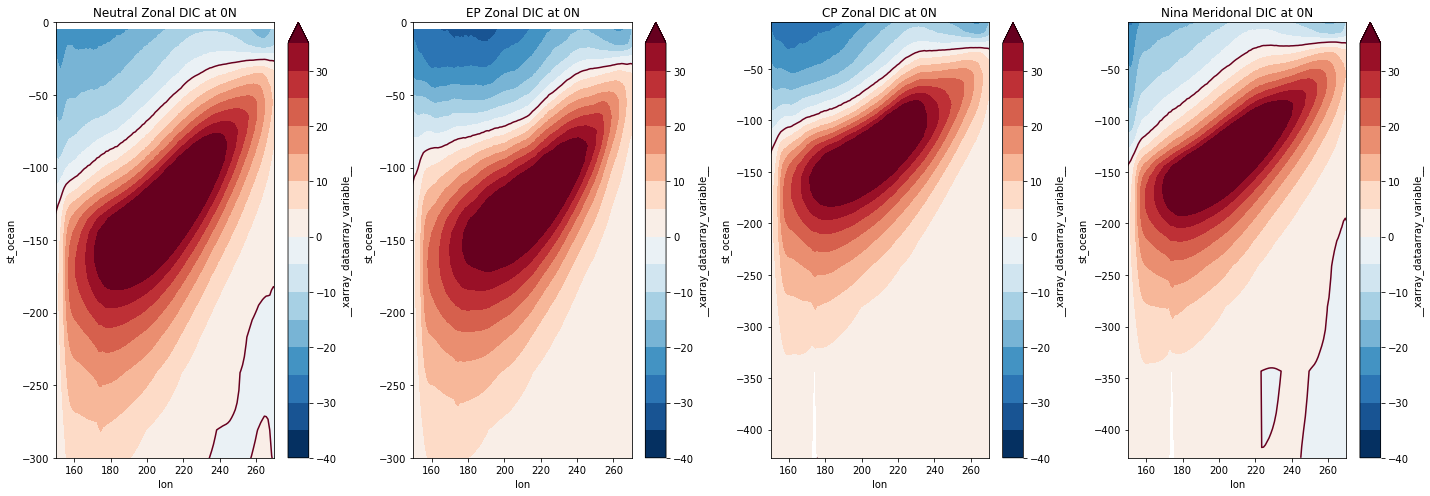